hourly-daily available capacity, daily bid
prices, daily market clearing prices as well as daily aggregate demand, water storage and
inflow levels. 

In [5]:
#librerias
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib



# 1. Datos

## Precios declarados (daily bid prices op1)

In [6]:
#precio de mercado energia mayorista
#nota: aca seria a nivel plata y configuracion, pero el problema es que el resto no están en ese nivel
archivo = "PreciodeOfertaDeclarado.csv"
df_declarado = pd.read_csv(archivo, sep=";", encoding="utf-8")
df_declarado


CodigoVariable       Fecha CodigoDuracion UnidadMedida CodigoPlanta  \
0      POF_Declarado  18/04/2025           PT1D      COP/kWh         ESMR   
1      POF_Declarado  18/04/2025           PT1D      COP/kWh         TDR1   
2      POF_Declarado  18/04/2025           PT1D      COP/kWh         URA1   
3      POF_Declarado  18/04/2025           PT1D      COP/kWh         CLMG   
4      POF_Declarado  18/04/2025           PT1D      COP/kWh         TFL4   
...              ...         ...            ...          ...          ...   
20029  POF_Declarado  18/06/2025           PT1D      COP/kWh         TSJ1   
20030  POF_Declarado  18/06/2025           PT1D      COP/kWh         GVIO   
20031  POF_Declarado  18/06/2025           PT1D      COP/kWh         MRL1   
20032  POF_Declarado  18/06/2025           PT1D      COP/kWh         TSR1   
20033  POF_Declarado  18/06/2025           PT1D      COP/kWh         ALBG   

       Configuracion    Valor  
0                  0   103.76  
1                  0  2306.46  
2                  0   250.00  
3                  0   920.00  
4                  4  1534.69  
...              ...      ...  
20029              0   287.00  
20030              0   103.50  
20031              0   947.87  
20032              9   887.56  
20033              0   102.95  

[20034 rows x 7 columns]

In [7]:
df_declarado[df_declarado['CodigoPlanta']=='TFL4']['Configuracion'].unique()

array([4, 3, 2, 1], dtype=int64)

In [8]:
# mi id es Planta_Configuracion
df_declarado['Planta_Configuracion'] = df_declarado['CodigoPlanta'].astype(str) + "_" + df_declarado['Configuracion'].astype(str)
df_declarado[['CodigoPlanta', 'Configuracion', 'Planta_Configuracion']]


CodigoPlanta  Configuracion Planta_Configuracion
0             ESMR              0               ESMR_0
1             TDR1              0               TDR1_0
2             URA1              0               URA1_0
3             CLMG              0               CLMG_0
4             TFL4              4               TFL4_4
...            ...            ...                  ...
20029         TSJ1              0               TSJ1_0
20030         GVIO              0               GVIO_0
20031         MRL1              0               MRL1_0
20032         TSR1              9               TSR1_9
20033         ALBG              0               ALBG_0

[20034 rows x 3 columns]

In [9]:
df_declarado['Fecha'].min()

'1/04/2025'

In [10]:
df_declarado['Fecha'].max()

'9/09/2025'

In [11]:
df_declarado

CodigoVariable       Fecha CodigoDuracion UnidadMedida CodigoPlanta  \
0      POF_Declarado  18/04/2025           PT1D      COP/kWh         ESMR   
1      POF_Declarado  18/04/2025           PT1D      COP/kWh         TDR1   
2      POF_Declarado  18/04/2025           PT1D      COP/kWh         URA1   
3      POF_Declarado  18/04/2025           PT1D      COP/kWh         CLMG   
4      POF_Declarado  18/04/2025           PT1D      COP/kWh         TFL4   
...              ...         ...            ...          ...          ...   
20029  POF_Declarado  18/06/2025           PT1D      COP/kWh         TSJ1   
20030  POF_Declarado  18/06/2025           PT1D      COP/kWh         GVIO   
20031  POF_Declarado  18/06/2025           PT1D      COP/kWh         MRL1   
20032  POF_Declarado  18/06/2025           PT1D      COP/kWh         TSR1   
20033  POF_Declarado  18/06/2025           PT1D      COP/kWh         ALBG   

       Configuracion    Valor Planta_Configuracion  
0                  0   103.76               ESMR_0  
1                  0  2306.46               TDR1_0  
2                  0   250.00               URA1_0  
3                  0   920.00               CLMG_0  
4                  4  1534.69               TFL4_4  
...              ...      ...                  ...  
20029              0   287.00               TSJ1_0  
20030              0   103.50               GVIO_0  
20031              0   947.87               MRL1_0  
20032              9   887.56               TSR1_9  
20033              0   102.95               ALBG_0  

[20034 rows x 8 columns]

In [12]:
#Precio de oferta de la planta en el proceso del despacho ideal, en COP/kWh - https://www.simem.co/datadetail/B1189F52-1F3C-429B-B1C5-34AF0AC860F7
# Precio de oferta de la planta para cada configuración ofertada en el proceso del despacho ideal, en COP/kWh - https://www.simem.co/datadetail/B180058C-52DD-42C3-A93A-F44003AA2D43

## Precio de oferta de la planta en el proceso del despacho ideal, en COP/kWh (daily bid prices op2)

In [13]:
#nota: acá sería a nivel planta y no desgloso configuracion, una planta y ya 
archivo_oferta = "Preciodeofertaplanta.csv"
df_oferta = pd.read_csv(archivo_oferta, sep=",", encoding="utf-8")
df_oferta
#2024-09-01

CodigoVariable            FechaHora CodigoDuracion UnidadMedida  \
0        POf_Original  2025-05-25 23:00:00            P1D      COP/kWh   
1        POf_Original  2025-05-25 22:00:00            P1D      COP/kWh   
2        POf_Original  2025-05-25 21:00:00            P1D      COP/kWh   
3        POf_Original  2025-05-25 20:00:00            P1D      COP/kWh   
4        POf_Original  2025-05-25 19:00:00            P1D      COP/kWh   
...               ...                  ...            ...          ...   
670603   POf_Original  2025-07-13 04:00:00            P1D      COP/kWh   
670604   POf_Original  2025-07-13 03:00:00            P1D      COP/kWh   
670605   POf_Original  2025-07-13 02:00:00            P1D      COP/kWh   
670606   POf_Original  2025-07-13 01:00:00            P1D      COP/kWh   
670607   POf_Original  2025-07-13 00:00:00            P1D      COP/kWh   

       CodigoPlanta Version    Valor  
0              TEC1     TXF  1486.46  
1              TEC1     TXF  1486.46  
2              TEC1     TXF  1486.46  
3              TEC1     TXF  1486.46  
4              TEC1     TXF  1486.46  
...             ...     ...      ...  
670603         ZPA2     TX4   379.71  
670604         ZPA2     TX4   379.71  
670605         ZPA2     TX4   379.71  
670606         ZPA2     TX4   379.71  
670607         ZPA2     TX4   379.71  

[670608 rows x 7 columns]

## Precio de bolsa horario (daily market clearing prices)

In [14]:
#precio mercado spot
archivo_bolsa = "Preciodebolsahorario.csv"
df_bolsa = pd.read_csv(archivo_bolsa, sep=",", encoding="utf-8")
df_bolsa

CodigoVariable            FechaHora CodigoDuracion UnidadMedida Version  \
0             PB_Int  2025-06-01 00:00:00           PT1H      COP/kWh     TX2   
1             PB_Int  2025-06-01 01:00:00           PT1H      COP/kWh     TX2   
2             PB_Int  2025-06-01 02:00:00           PT1H      COP/kWh     TX2   
3             PB_Int  2025-06-01 03:00:00           PT1H      COP/kWh     TX2   
4             PB_Int  2025-06-01 04:00:00           PT1H      COP/kWh     TX2   
...              ...                  ...            ...          ...     ...   
59443         PB_Tie  2025-05-18 19:00:00           PT1H      COP/kWh     TXF   
59444         PB_Tie  2025-05-18 20:00:00           PT1H      COP/kWh     TXF   
59445         PB_Tie  2025-05-18 21:00:00           PT1H      COP/kWh     TXF   
59446         PB_Tie  2025-05-18 22:00:00           PT1H      COP/kWh     TXF   
59447         PB_Tie  2025-05-18 23:00:00           PT1H      COP/kWh     TXF   

        Valor  
0      193.75  
1      193.75  
2      193.75  
3      193.75  
4      193.75  
...       ...  
59443  106.39  
59444  106.39  
59445  106.39  
59446  102.64  
59447  102.64  

[59448 rows x 6 columns]

## Disponibilidad Comercial por Planta (hourly-daily available capacity)

Es la disponibilidad calculada por el Sistema de Intercambios Comerciales, la cual considera la declaración de disponibilidad de las plantas de generación, modificada cuando se presenten cambios en las unidades de generación en la operación real del sistema resolución CREG 024 del 095

Saber cuánta energía puede generar cada planta en cada hora

In [15]:
#https://www.simem.co/datadetail/24F4EC70-2DA0-4551-A188-FA750A7D66A5

julio = pd.read_csv("Disponibilidadcomercialporplantajulio.csv", sep=',', encoding='utf-8')
septiembre = pd.read_csv("Disponibilidadcomercialporplantaseptiembre.csv", sep=',', encoding='utf-8')

# Concatenar verticalmente
df_capacity = pd.concat([julio, septiembre], axis=0)

# Eliminar duplicados exactos
df_capacity = df_capacity.drop_duplicates()
df_capacity = df_capacity.reset_index(drop=True)
df_capacity


#nota: si hay algo que no aparezca es porque sus cantidades disponibles en esa hora eran 0



CodigoVariable            FechaHora CodigoDuracion UnidadMedida  \
0              DispCom  2025-05-25 16:00:00           PT1H          kWh   
1              DispCom  2025-05-25 15:00:00           PT1H          kWh   
2              DispCom  2025-05-25 14:00:00           PT1H          kWh   
3              DispCom  2025-05-25 13:00:00           PT1H          kWh   
4              DispCom  2025-05-25 12:00:00           PT1H          kWh   
...                ...                  ...            ...          ...   
2946659        DispCom  2025-08-10 04:00:00           PT1H          kWh   
2946660        DispCom  2025-08-10 03:00:00           PT1H          kWh   
2946661        DispCom  2025-08-10 02:00:00           PT1H          kWh   
2946662        DispCom  2025-08-10 01:00:00           PT1H          kWh   
2946663        DispCom  2025-08-10 00:00:00           PT1H          kWh   

        Version    Valor CodigoPlanta  
0           TX3   148.56         3ACC  
1           TX3  2706.61         3ACC  
2           TX3  3574.43         3ACC  
3           TX3  3642.49         3ACC  
4           TX3  5078.19         3ACC  
...         ...      ...          ...  
2946659     TX1  2825.03         VNTB  
2946660     TX1  2842.82         VNTB  
2946661     TX1  2855.33         VNTB  
2946662     TX1  2869.57         VNTB  
2946663     TX1  2897.92         VNTB  

[2946664 rows x 7 columns]

In [16]:
#verificando que estas sean las capacidades declaradas, porque despues aparecen en equilibrio. Rta: sí coinciden

In [17]:
df_capacity[
    (df_capacity['CodigoPlanta'] == '2QBW') &
    (df_capacity['FechaHora'].astype(str).str.contains('2025-08-11 00:00:00'))
]

CodigoVariable            FechaHora CodigoDuracion UnidadMedida  \
2257328        DispCom  2025-08-11 00:00:00           PT1H          kWh   
2263080        DispCom  2025-08-11 00:00:00           PT1H          kWh   

        Version    Valor CodigoPlanta  
2257328     TX2  18008.4         2QBW  
2263080     TX1  18008.4         2QBW

In [18]:
df_capacity[
    (df_capacity['CodigoPlanta'] == '2QEK') &
    (df_capacity['FechaHora'].astype(str).str.contains('2025-08-11 00:00:00'))
]

CodigoVariable            FechaHora CodigoDuracion UnidadMedida  \
2253197        DispCom  2025-08-11 00:00:00           PT1H          kWh   
2261712        DispCom  2025-08-11 00:00:00           PT1H          kWh   

        Version    Valor CodigoPlanta  
2253197     TX2  35000.0         2QEK  
2261712     TX1  35000.0         2QEK

## Pronóstico del CND de demanda por Área operativa (daily aggregate demand)

In [19]:
#https://www.simem.co/datadetail/A016BAC9-EAA1-45BB-8DB2-AE01600E1D18
archivo_pronostico= "PronósticodelCNDdedemandaporÁreaoperativa.csv"
df_pronostico = pd.read_csv(archivo_pronostico, sep=",", encoding="utf-8")
df_pronostico



FechaPublicacion            FechaHora CodigoDuracion  \
0           2025-05-01  2025-04-05 00:00:00           PT1H   
1           2025-05-01  2025-04-05 01:00:00           PT1H   
2           2025-05-01  2025-04-05 02:00:00           PT1H   
3           2025-05-01  2025-04-05 03:00:00           PT1H   
4           2025-05-01  2025-04-05 04:00:00           PT1H   
...                ...                  ...            ...   
19435       2025-06-01  2025-05-22 19:00:00           PT1H   
19436       2025-06-01  2025-05-22 20:00:00           PT1H   
19437       2025-06-01  2025-05-22 21:00:00           PT1H   
19438       2025-06-01  2025-05-22 22:00:00           PT1H   
19439       2025-06-01  2025-05-22 23:00:00           PT1H   

      CodigoAreaOperativa    PronDem  
0                 Are0002  1017494.3  
1                 Are0002   975345.5  
2                 Are0002   946246.0  
3                 Are0002   937971.4  
4                 Are0002   963633.8  
...                   ...        ...  
19435             Are0128  2325697.5  
19436             Are0128  2237126.5  
19437             Are0128  2014845.2  
19438             Are0128  1825030.4  
19439             Are0128  1664199.3  

[19440 rows x 5 columns]

In [20]:
df_pronostico_agg = (
    df_pronostico.groupby("FechaHora", as_index=False)["PronDem"]
      .sum()
      .rename(columns={"PronDem": "daily_agg_demand"})
)
df_pronostico_agg #lo que se pronosticó demandado

FechaHora  daily_agg_demand
0     2025-04-01 00:00:00         8381365.2
1     2025-04-01 01:00:00         8102281.3
2     2025-04-01 02:00:00         7913273.6
3     2025-04-01 03:00:00         7823041.2
4     2025-04-01 04:00:00         7999010.4
...                   ...               ...
3883  2025-09-09 19:00:00        11599381.0
3884  2025-09-09 20:00:00        11396855.1
3885  2025-09-09 21:00:00        10584341.3
3886  2025-09-09 22:00:00         9935794.2
3887  2025-09-09 23:00:00         9327720.3

[3888 rows x 2 columns]

## Despacho programado recursos de generación (cantidades de equilibrio)


Contiene el programa de generación del despacho económico en kW, cotejar info con pronostico CND, tmb insumo para cantidades declaradas

In [21]:
#https://www.simem.co/datadetail/FF027B64-9896-4844-B827-9DC05F690668
archivo_despacho = "Despachoprogramadorecursosdegeneracion.csv"
df_despacho = pd.read_csv(archivo_despacho, sep=",", encoding="utf-8")
df_despacho
#valor es kW

FechaHora CodigoDuracion CodigoElementoGeneracion   Valor
0        2025-08-11 00:00:00           PT1H                     2QBW   18380
1        2025-08-11 00:00:00           PT1H                     2QEK   35000
2        2025-08-11 00:00:00           PT1H                     2QRL     650
3        2025-08-11 00:00:00           PT1H                     2QV2    6000
4        2025-08-11 00:00:00           PT1H                     2R22   18000
...                      ...            ...                      ...     ...
1264514  2025-04-05 23:00:00           PT1H                     SLVJ   95000
1264515  2025-04-05 23:00:00           PT1H                     SMI1   25000
1264516  2025-04-05 23:00:00           PT1H                     SNC1     700
1264517  2025-04-05 23:00:00           PT1H                     SNCR  729000
1264518  2025-04-05 23:00:00           PT1H                     SNFR       0

[1264519 rows x 4 columns]

In [22]:
df_despacho_agg = (
    df_despacho.groupby("FechaHora", as_index=False)["Valor"]
      .sum()
      .rename(columns={"Valor": "daily_eq_demand"})
)
df_despacho_agg #fue lo que se despachó al final demandado

FechaHora  daily_eq_demand
0     2025-04-01 00:00:00          8634480
1     2025-04-01 01:00:00          8343930
2     2025-04-01 02:00:00          8149800
3     2025-04-01 03:00:00          8060810
4     2025-04-01 04:00:00          8231010
...                   ...              ...
3883  2025-09-09 19:00:00         11822380
3884  2025-09-09 20:00:00         11697040
3885  2025-09-09 21:00:00         11140860
3886  2025-09-09 22:00:00         10420020
3887  2025-09-09 23:00:00          9877640

[3888 rows x 2 columns]

In [23]:
df_despacho[df_despacho['CodigoElementoGeneracion']=='TFL4']

FechaHora CodigoDuracion CodigoElementoGeneracion   Valor
8275     2025-07-02 01:00:00           PT1H                     TFL4  120000
8582     2025-07-02 02:00:00           PT1H                     TFL4  120000
8889     2025-07-02 03:00:00           PT1H                     TFL4  120000
9196     2025-07-02 04:00:00           PT1H                     TFL4  120000
9393     2025-07-02 05:00:00           PT1H                     TFL4  120000
...                      ...            ...                      ...     ...
1263238  2025-04-05 17:00:00           PT1H                     TFL4       0
1263578  2025-04-05 19:00:00           PT1H                     TFL4       0
1263820  2025-04-05 20:00:00           PT1H                     TFL4       0
1264020  2025-04-05 21:00:00           PT1H                     TFL4       0
1264300  2025-04-05 22:00:00           PT1H                     TFL4       0

[2400 rows x 4 columns]

In [24]:
#otras opciones: Demanda comercial, en kWh. Demanda real, en kWh.

## Reservas hidraulicas

In [25]:
#https://www.simem.co/datadetail/9605B04C-8D3A-40A9-94D3-5535670D2F9A
archivo_hidraulica = "ReservasHidráulicas.csv"
df_hidraulica = pd.read_csv(archivo_hidraulica, sep=",", encoding="utf-8")
df_hidraulica


FechaPublicacion       Fecha CodigoDuracion CodigoEmbalse  \
0          2025-06-29  2025-06-28            P1D      ALTOANCH   
1          2025-06-29  2025-06-28            P1D       ITUANGO   
2          2025-06-29  2025-06-28            P1D      PUNCHINA   
3          2025-06-29  2025-06-28            P1D        PORCE3   
4          2025-06-29  2025-06-28            P1D       BETANIA   
...               ...         ...            ...           ...   
4353       2025-08-26  2025-08-25            P1D        TOMINE   
4354       2025-08-26  2025-08-25            P1D      TRONERAS   
4355       2025-08-26  2025-08-25            P1D          MUNA   
4356       2025-08-26  2025-08-25            P1D        PORCE2   
4357       2025-08-26  2025-08-25            P1D         NEUSA   

     RegionHidrologica  VolumenUtilDiarioMasa  VolumenTotalMasa  
0                Valle               11200000          17520000  
1            Antioquia              116260000        1415260000  
2            Antioquia               42210000          56190000  
3            Antioquia               79080000         108530000  
4               Centro              673527000        1129027000  
...                ...                    ...               ...  
4353            CENTRO              398310000         398310000  
4354         Antioquia                7740000          16190000  
4355            Centro               11910000          11990000  
4356         Antioquia               50140000          88930000  
4357            CENTRO               96790000          96790100  

[4358 rows x 7 columns]

In [26]:
df_hidraulica_avg= (
    df_hidraulica
    .groupby('Fecha', as_index=False)[['VolumenUtilDiarioMasa', 'VolumenTotalMasa']]
    .mean()
)


Dias similares

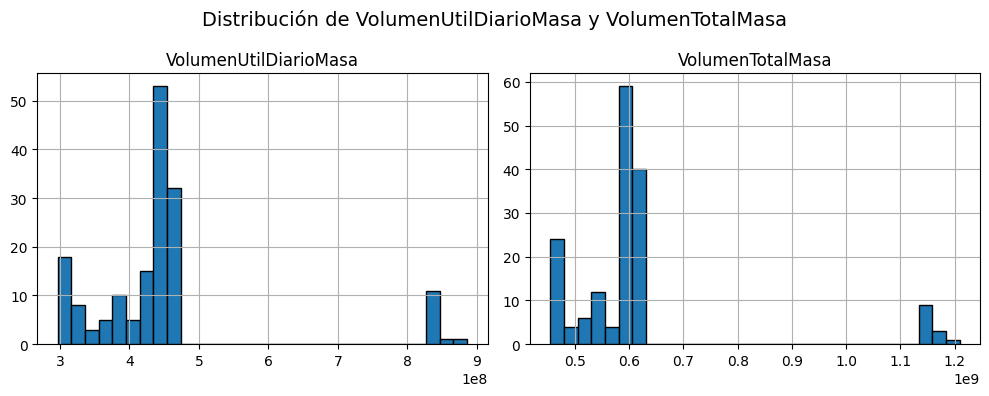

In [27]:
import matplotlib.pyplot as plt

# Lista de variables a graficar
vars_plot = ['VolumenUtilDiarioMasa', 'VolumenTotalMasa']

# Crea los histogramas uno al lado del otro
df_hidraulica_avg[vars_plot].hist(
    bins=30,           # número de barras
    figsize=(10, 4),   # tamaño del gráfico
    edgecolor='black'  # bordes para mejor visibilidad
)

plt.suptitle('Distribución de VolumenUtilDiarioMasa y VolumenTotalMasa', fontsize=14)
plt.tight_layout()
plt.show()


In [28]:
from sklearn.cluster import KMeans
import pandas as pd

# 1. Seleccionar la variable
X = df_hidraulica_avg[['VolumenUtilDiarioMasa']].values

# 2. Aplicar K-Means con 12 grupos
kmeans = KMeans(n_clusters=12, random_state=42)
df_hidraulica_avg['cluster'] = kmeans.fit_predict(X)

# 3. Reordenar los clusters según el valor medio (1 = menor, 12 = mayor)
cluster_means = (
    df_hidraulica_avg.groupby('cluster')['VolumenUtilDiarioMasa']
    .mean()
    .sort_values()
)
orden_map = {old: new + 1 for new, old in enumerate(cluster_means.index)}
df_hidraulica_avg['cluster'] = df_hidraulica_avg['cluster'].map(orden_map)

# 4. Verificar
print(df_hidraulica_avg[['Fecha', 'VolumenUtilDiarioMasa', 'cluster']].head())

# 5. Resumen por cluster
resumen = (
    df_hidraulica_avg.groupby('cluster')['VolumenUtilDiarioMasa']
    .agg(['count', 'mean', 'min', 'max'])
    .sort_index()
)
print(resumen)


        Fecha  VolumenUtilDiarioMasa  cluster
0  2025-04-01           2.969186e+08        1
1  2025-04-02           2.970081e+08        1
2  2025-04-03           2.971947e+08        1
3  2025-04-04           2.981375e+08        1
4  2025-04-05           3.019760e+08        1
         count          mean           min           max
cluster                                                 
1           24  3.099078e+08  2.969186e+08  3.217660e+08
2            5  3.377511e+08  3.241564e+08  3.503973e+08
3            6  3.670548e+08  3.582817e+08  3.764841e+08
4           13  3.950024e+08  3.882780e+08  4.060557e+08
5           14  4.239925e+08  4.119788e+08  4.286237e+08
6           37  4.384967e+08  4.323997e+08  4.414406e+08
7           12  4.456888e+08  4.423426e+08  4.487055e+08
8           25  4.548213e+08  4.503221e+08  4.596065e+08
9           13  4.644893e+08  4.600609e+08  4.722815e+08
10           8  8.354724e+08  8.315556e+08  8.396919e+08
11           4  8.455813e+08  8.409993e+

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [29]:
df_hidraulica_avg

Fecha  VolumenUtilDiarioMasa  VolumenTotalMasa  cluster
0    2025-04-01           2.969186e+08      4.542842e+08        1
1    2025-04-02           2.970081e+08      4.544695e+08        1
2    2025-04-03           2.971947e+08      4.545602e+08        1
3    2025-04-04           2.981375e+08      4.564693e+08        1
4    2025-04-05           3.019760e+08      4.593416e+08        1
..          ...                    ...               ...      ...
157  2025-09-05           8.368711e+08      1.151515e+09       10
158  2025-09-06           8.368356e+08      1.151479e+09       10
159  2025-09-07           8.450015e+08      1.159645e+09       11
160  2025-09-08           8.504281e+08      1.165072e+09       11
161  2025-09-09           8.458963e+08      1.160540e+09       11

[162 rows x 4 columns]

In [30]:
df_hidraulica['Fecha'].min()

'2025-04-01'

# 2. Procesamiento de datos

In [31]:
df_oferta[['FechaHora', 'CodigoPlanta', 'Valor']]

FechaHora CodigoPlanta    Valor
0       2025-05-25 23:00:00         TEC1  1486.46
1       2025-05-25 22:00:00         TEC1  1486.46
2       2025-05-25 21:00:00         TEC1  1486.46
3       2025-05-25 20:00:00         TEC1  1486.46
4       2025-05-25 19:00:00         TEC1  1486.46
...                     ...          ...      ...
670603  2025-07-13 04:00:00         ZPA2   379.71
670604  2025-07-13 03:00:00         ZPA2   379.71
670605  2025-07-13 02:00:00         ZPA2   379.71
670606  2025-07-13 01:00:00         ZPA2   379.71
670607  2025-07-13 00:00:00         ZPA2   379.71

[670608 rows x 3 columns]

In [32]:
df_bolsa[['FechaHora', 'Valor']]

FechaHora   Valor
0      2025-06-01 00:00:00  193.75
1      2025-06-01 01:00:00  193.75
2      2025-06-01 02:00:00  193.75
3      2025-06-01 03:00:00  193.75
4      2025-06-01 04:00:00  193.75
...                    ...     ...
59443  2025-05-18 19:00:00  106.39
59444  2025-05-18 20:00:00  106.39
59445  2025-05-18 21:00:00  106.39
59446  2025-05-18 22:00:00  102.64
59447  2025-05-18 23:00:00  102.64

[59448 rows x 2 columns]

In [33]:
df_despacho_agg['daily_eq_demand']

0        8634480
1        8343930
2        8149800
3        8060810
4        8231010
          ...   
3883    11822380
3884    11697040
3885    11140860
3886    10420020
3887     9877640
Name: daily_eq_demand, Length: 3888, dtype: int64

In [34]:
df_capacity[['FechaHora','Valor', 'CodigoPlanta']]

FechaHora    Valor CodigoPlanta
0        2025-05-25 16:00:00   148.56         3ACC
1        2025-05-25 15:00:00  2706.61         3ACC
2        2025-05-25 14:00:00  3574.43         3ACC
3        2025-05-25 13:00:00  3642.49         3ACC
4        2025-05-25 12:00:00  5078.19         3ACC
...                      ...      ...          ...
2946659  2025-08-10 04:00:00  2825.03         VNTB
2946660  2025-08-10 03:00:00  2842.82         VNTB
2946661  2025-08-10 02:00:00  2855.33         VNTB
2946662  2025-08-10 01:00:00  2869.57         VNTB
2946663  2025-08-10 00:00:00  2897.92         VNTB

[2946664 rows x 3 columns]

In [35]:
# Renombrar columnas antes del merge
df_oferta_renamed = df_oferta[['FechaHora', 'CodigoPlanta', 'Valor']].rename(columns={'Valor': 'precio'})
df_capacity_renamed = df_capacity[['FechaHora','Valor', 'CodigoPlanta']].rename(columns={'Valor': 'cantidad'})

df_merged = df_oferta_renamed.merge(
    df_capacity_renamed,
    on=['FechaHora', 'CodigoPlanta'],
    how='left'
)

# Reemplazar NaN en cantidad por 0
df_merged['cantidad'] = df_merged['cantidad'].fillna(0)
df_merged = df_merged.drop_duplicates(subset=['FechaHora', 'CodigoPlanta'], keep='first')
df_merged


FechaHora CodigoPlanta   precio  cantidad
0        2025-05-25 23:00:00         TEC1  1486.46  213000.0
3        2025-05-25 22:00:00         TEC1  1486.46  213000.0
6        2025-05-25 21:00:00         TEC1  1486.46  213000.0
9        2025-05-25 20:00:00         TEC1  1486.46  213000.0
12       2025-05-25 19:00:00         TEC1  1486.46  213000.0
...                      ...          ...      ...       ...
1817655  2025-07-13 04:00:00         TGJ1   557.16       0.0
1817656  2025-07-13 03:00:00         TGJ1   557.16       0.0
1817657  2025-07-13 02:00:00         TGJ1   557.16       0.0
1817658  2025-07-13 01:00:00         TGJ1   557.16       0.0
1817659  2025-07-13 00:00:00         TGJ1   557.16       0.0

[307152 rows x 4 columns]

In [36]:
df_merged['Fecha'] = pd.to_datetime(df_merged['FechaHora']).dt.date

In [37]:
df_hidraulica_avg['Fecha'] = pd.to_datetime(df_hidraulica_avg['Fecha']).dt.date

## Merges

In [38]:
df_final = pd.merge(
    df_merged,
    df_hidraulica_avg[['Fecha', 'cluster']],
    on='Fecha',
    how='inner'
)
df_final

FechaHora CodigoPlanta   precio  cantidad       Fecha  \
0       2025-05-25 23:00:00         TEC1  1486.46  213000.0  2025-05-25   
1       2025-05-25 22:00:00         TEC1  1486.46  213000.0  2025-05-25   
2       2025-05-25 21:00:00         TEC1  1486.46  213000.0  2025-05-25   
3       2025-05-25 20:00:00         TEC1  1486.46  213000.0  2025-05-25   
4       2025-05-25 19:00:00         TEC1  1486.46  213000.0  2025-05-25   
...                     ...          ...      ...       ...         ...   
307147  2025-07-13 04:00:00         TGJ1   557.16       0.0  2025-07-13   
307148  2025-07-13 03:00:00         TGJ1   557.16       0.0  2025-07-13   
307149  2025-07-13 02:00:00         TGJ1   557.16       0.0  2025-07-13   
307150  2025-07-13 01:00:00         TGJ1   557.16       0.0  2025-07-13   
307151  2025-07-13 00:00:00         TGJ1   557.16       0.0  2025-07-13   

        cluster  
0             5  
1             5  
2             5  
3             5  
4             5  
...         ...  
307147        9  
307148        9  
307149        9  
307150        9  
307151        9  

[307152 rows x 6 columns]

In [39]:
df_despacho[df_despacho['CodigoElementoGeneracion'] == 'TEC1']

FechaHora CodigoDuracion CodigoElementoGeneracion  Valor
45566    2025-04-24 00:00:00           PT1H                     TEC1      0
45942    2025-04-24 01:00:00           PT1H                     TEC1      0
46138    2025-04-24 02:00:00           PT1H                     TEC1      0
46468    2025-04-24 03:00:00           PT1H                     TEC1      0
46703    2025-04-24 04:00:00           PT1H                     TEC1      0
...                      ...            ...                      ...    ...
1263236  2025-04-05 17:00:00           PT1H                     TEC1      0
1263576  2025-04-05 19:00:00           PT1H                     TEC1      0
1263818  2025-04-05 20:00:00           PT1H                     TEC1      0
1264018  2025-04-05 21:00:00           PT1H                     TEC1      0
1264298  2025-04-05 22:00:00           PT1H                     TEC1      0

[744 rows x 4 columns]

In [40]:
#verificacion
df_despacho[
    (df_despacho['CodigoElementoGeneracion'] == 'TEC1') &
    (df_despacho['FechaHora'].str.contains('2025-05-25'))
]

#no aparece, en realidad no despacha porque es que está por encima del precio de cierre, muy por encima entonces no se toma

Empty DataFrame
Columns: [FechaHora, CodigoDuracion, CodigoElementoGeneracion, Valor]
Index: []

In [41]:
#transado en el cierre

df_transado = pd.merge(
    df_bolsa[['FechaHora', 'Valor']],
    df_despacho_agg[['FechaHora', 'daily_eq_demand']],
    on='FechaHora',
    how='left'
)
df_transado = df_transado.rename(columns={
    'Valor': 'precio',
    'daily_eq_demand': 'demanda'
})

df_transado

FechaHora  precio   demanda
0      2025-06-01 00:00:00  193.75   8415370
1      2025-06-01 01:00:00  193.75   8105260
2      2025-06-01 02:00:00  193.75   7921330
3      2025-06-01 03:00:00  193.75   7750260
4      2025-06-01 04:00:00  193.75   7630180
...                    ...     ...       ...
59443  2025-05-18 19:00:00  106.39  10162760
59444  2025-05-18 20:00:00  106.39  10115880
59445  2025-05-18 21:00:00  106.39   9423060
59446  2025-05-18 22:00:00  102.64   8997340
59447  2025-05-18 23:00:00  102.64   8515830

[59448 rows x 3 columns]

In [42]:
df_final=df_final[df_final['cantidad']!=0]

In [43]:
# Asegurarse de que las columnas 'FechaHora' sean datetime
df_final['FechaHora'] = pd.to_datetime(df_final['FechaHora'])
df_transado['FechaHora'] = pd.to_datetime(df_transado['FechaHora'])

# Filtrar df_transado: solo fechas que aparecen en df_final
df_transado_filtrado = df_transado[df_transado['FechaHora'].isin(df_final['FechaHora'])]

# Filtrar df_final: solo fechas que aparecen en df_transado_filtrado
df_final_filtrado = df_final[df_final['FechaHora'].isin(df_transado_filtrado['FechaHora'])]


C:\Users\HP\AppData\Local\Temp\ipykernel_26800\3090825170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['FechaHora'] = pd.to_datetime(df_final['FechaHora'])


# 3. Estimation 

logica: miro una fecha y un bidder, miro sus competidores, busco dias similares y comportamiento de sus competidores. Despues miro M muestra boostratps, como escenarios y veo el equilibrio, de como juegan sus competidores. Después miro, en cada una de esas M muestras bootstratps para ese dia hallo la derivada, despues hago el promedio sobre todas las muestras bootstratps. Depues hago la suma sobre todas las horas y eso va a ser el phi, con los otros terminos

### Define Parameters

In [44]:
# -------------------------
# BOOTSTRAP POR PERFILES firma-día (J perfiles por réplica)
# -------------------------
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm.auto import tqdm

# Parámetros (ajusta según tu CPU / tamaño de datos)
M = 3           # número de réplicas bootstrap por (i,t)
J = 2            # número de perfiles (firm-day) que se muestrean por réplica (competidores)
gamma = 50.0      # bandwidth del kernel (ajusta según escala de precios)
random_state = 123
np.random.seed(random_state)

In [45]:
#faltan meter las horas, o sea suar con 23, 

#ahora: se hace esto para todas las horas del día 2025-07-01 y la empresa TEC1 y sumo eso, en las 24 horas del dia, y ese es el termino ponderado!!!

##vamos bieeeen

In [46]:
# ----------------------------------------------------
# LIBRERÍAS
# ----------------------------------------------------
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing

# ----------------------------------------------------
# FUNCIONES AUXILIARES
# ----------------------------------------------------

def get_cluster_it(df, fecha, firma):
    """Devuelve el cluster correspondiente a una firma i en una FechaHora t."""
    return df.loc[
        (df['FechaHora'] == fecha) & (df['CodigoPlanta'] == firma),
        'cluster'
    ].iloc[0]

def get_competitors(df, fecha, firma):
    """Devuelve los competidores (otros CodigoPlanta) presentes en la misma FechaHora."""
    df_day = df[df['FechaHora'] == fecha]
    competitors = df_day.loc[df_day['CodigoPlanta'] != firma, 'CodigoPlanta'].unique().tolist()
    return competitors

def get_similar_days_by_cluster(df, fecha, firma):
    """Busca días similares según el cluster del competidor k != i."""
    cluster_it = get_cluster_it(df, fecha, firma)
    competitors = get_competitors(df, fecha, firma)
    
    similar_obs = []
    for comp in competitors:
        df_comp_similar = df[
            (df['CodigoPlanta'] == comp) & (df['cluster'] == cluster_it)
        ].copy()
         
        if len(df_comp_similar) > 20:
            df_comp_similar = df_comp_similar.sample(n=20, random_state=42)

        df_comp_similar['competidor_de'] = firma
        df_comp_similar['fecha_base'] = fecha
        similar_obs.append(df_comp_similar)
    
    if similar_obs:
        return pd.concat(similar_obs, ignore_index=True)
    else:
        return pd.DataFrame()

def bootstrap_by_planta(df, M, seed=None):
    """Genera M muestras bootstrap independientes por planta."""
    if seed is not None:
        np.random.seed(seed)

    plantas = df['CodigoPlanta'].unique()
    bootstrap_samples = []

    for m in range(M):
        muestras = []
        for p in plantas:
            df_p = df[df['CodigoPlanta'] == p]
            if len(df_p) == 0:
                continue
            muestra = df_p.sample(1, replace=True)
            muestra['bootstrap_id'] = m + 1
            muestras.append(muestra)
        sample_df = pd.concat(muestras).reset_index(drop=True)
        bootstrap_samples.append(sample_df)

    return bootstrap_samples

def compute_equilibrium(df_day, df_transado):
    """Encuentra el precio y cantidad de equilibrio p*, q*."""
    fecha = df_day['FechaHora'].iloc[0]
    demanda_row = df_transado.loc[df_transado['FechaHora'] == fecha, 'demanda']
    if demanda_row.empty:
        raise ValueError(f"No se encontró demanda para la fecha {fecha} en df_transado.")
    
    demand = demanda_row.iloc[0]
    df_sorted = df_day.sort_values('precio').copy()
    df_sorted['acum'] = df_sorted['cantidad'].cumsum()
    clearing = df_sorted[df_sorted['acum'] >= demand].iloc[0]
    p_star = clearing['precio']
    q_star = demand
    return p_star, q_star

# ----------------------------------------------------
# KERNELS
# ----------------------------------------------------

def gaussian_kernel(x):
    """Kernel Gaussiano estándar."""
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

def kernel_derivative(df, p_ht, gamma):
    """Derivada condicional (denominador)."""
    df = df.copy()
    df["kernel_weight"] = gaussian_kernel((df["precio"] - p_ht) / gamma)
    df["term"] = (1 / gamma) * df["cantidad"] * df["kernel_weight"]
    return df["term"].sum()

def kernel_expectation(df, p_ht, gamma):
    """Cantidad esperada condicionada (numerador)."""
    pos = 0
    df = df.copy()
    df["kernel_weight"] = gaussian_kernel((df["precio"] - p_ht) / gamma)
    df["term"] = (df["cantidad"] - pos) * df["kernel_weight"]
    return df["term"].sum()

# ----------------------------------------------------
# PROMEDIO SOBRE BOOTSTRAP
# ----------------------------------------------------

def average_numerador_denom(df_bootstrap_list, df_transado, gamma):
    numer_values = []
    denom_values = []

    for i, df_bs in enumerate(df_bootstrap_list):
        p_ht_bs, _ = compute_equilibrium(df_bs, df_transado)
        numer = kernel_expectation(df_bs, p_ht_bs, gamma)
        denom = kernel_derivative(df_bs, p_ht_bs, gamma)
        numer_values.append(numer)
        denom_values.append(denom)
        
    avg_numer = np.mean(numer_values)
    avg_denom = np.mean(denom_values)
    return avg_numer, avg_denom, p_ht_bs



In [50]:
# ----------------------------------------------------
# FUNCIÓN PRINCIPAL CON PARALELIZACIÓN Y PROGRESO
# ----------------------------------------------------

def calcular_avg_Q_y_dQdb(df, df_transado, gamma, M=10, seed=123, n_jobs=-1):
    """
    Calcula promedio del numerador y denominador kernelizados en paralelo.
    Muestra una barra de progreso y prints detallados para las primeras 10 observaciones.
    """
    def procesar_fila(idx, row):
        fecha = row['FechaHora']
        firma = row['CodigoPlanta']
        df_similares = get_similar_days_by_cluster(df, fecha, firma)

        # Mostrar detalles solo para las primeras 10 observaciones
        if idx < 10:
            print("="*50)
            print(f"[{idx}] df_similares para {firma} en {fecha}")
            print("="*50)
            print(df_similares)
            print("="*50)

        if df_similares.empty:
            return np.nan, np.nan

        df_bootstrap_list = bootstrap_by_planta(df_similares, M=M, seed=seed)

        if idx < 10:
            pd.set_option('display.max_rows', None)
            print("="*50)
            print(f"[{idx}] df_bootstrap_list (primeros {len(df_bootstrap_list)} bootstraps)")
            print("="*50)
            print(df_bootstrap_list)
            print("="*50)
            pd.set_option('display.max_rows', 10)

        avg_numer, avg_denom, p_ht_bs = average_numerador_denom(df_bootstrap_list, df_transado, gamma)

        if idx < 10:
            print(f"Observación {idx+1}, p* = {p_ht_bs}")

        return avg_numer, avg_denom

    # ----------------------------------------------------
    # Progreso con tqdm + joblib
    # ----------------------------------------------------
    total = len(df)
    with tqdm_joblib(tqdm(total=total, desc="Calculando numerador y denominador", unit="obs")):
        resultados = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(procesar_fila)(idx, row) for idx, row in df.iterrows()
        )

    # ----------------------------------------------------
    # Agregar resultados al dataframe
    # ----------------------------------------------------
    resultados_numer, resultados_denom = zip(*resultados)
    df = df.copy()
    df['EQpos'] = resultados_numer
    df['EdQb'] = resultados_denom
    return df


In [51]:
# Solo la primera vez (si no tienes tqdm_joblib)
# pip install tqdm joblib tqdm_joblib

df_resultado = calcular_avg_Q_y_dQdb(
    df=df_final,
    df_transado=df_transado,
    gamma=0.5,
    M=1,
    seed=123,
    n_jobs=-1  # Usa todos los núcleos
)


Calculando numerador y denominador:   0%|                                                  | 0/244102 [00:00<?, ?obs/s]

  0%|          | 0/244102 [00:00<?, ?it/s]

Calculando numerador y denominador:   0%|                                               | 0/244102 [22:51:38<?, ?obs/s]


In [53]:
df_resultado.to_csv("df_result_fullsample_010425.csv", index=False)


In [107]:
df_result = pd.read_csv('df_result_fullsample_010425.csv')
df_result = df_result.rename(columns={'EQpos*': 'EQpos'})
df_result

FechaHora CodigoPlanta   precio  cantidad       Fecha  \
0       2025-05-25 23:00:00         TEC1  1486.46  213000.0  2025-05-25   
1       2025-05-25 22:00:00         TEC1  1486.46  213000.0  2025-05-25   
2       2025-05-25 21:00:00         TEC1  1486.46  213000.0  2025-05-25   
3       2025-05-25 20:00:00         TEC1  1486.46  213000.0  2025-05-25   
4       2025-05-25 19:00:00         TEC1  1486.46  213000.0  2025-05-25   
...                     ...          ...      ...       ...         ...   
244097  2025-07-13 04:00:00         CHBG   108.68  525000.0  2025-07-13   
244098  2025-07-13 03:00:00         CHBG   108.68  525000.0  2025-07-13   
244099  2025-07-13 02:00:00         CHBG   108.68  525000.0  2025-07-13   
244100  2025-07-13 01:00:00         CHBG   108.68  525000.0  2025-07-13   
244101  2025-07-13 00:00:00         CHBG   108.68  525000.0  2025-07-13   

        cluster          EQpos           EdQb  
0             5  207191.577877  414383.155754  
1             5  207191.577877  414383.155754  
2             5  463262.468522  926524.937044  
3             5  463262.468522  926524.937044  
4             5  463262.468522  926524.937044  
...         ...            ...            ...  
244097        9   65825.476266  131650.952532  
244098        9   65825.476266  131650.952532  
244099        9   65825.476266  131650.952532  
244100        9   65825.476266  131650.952532  
244101        9   65825.476266  131650.952532  

[244102 rows x 8 columns]

## Agregar columnas de numerador y denominador 

In [108]:

df_result['FechaHora'] = pd.to_datetime(df_result['FechaHora'], errors='coerce')

# Crear la variable de fecha (día calendario)
df_result['Fecha'] = df_result['FechaHora'].dt.date

# Agrupar por Fecha y CodigoPlanta
df_grouped = (
    df_result.groupby(['Fecha', 'CodigoPlanta'], as_index=False)
      .agg(
          numerador=('EQpos', 'sum'),
          denominador=('EdQb', 'sum'),
          precio_d=('precio', 'first'),
          
      )
)


# Combinar ambos dataframes
df_result2 = df_grouped

## Costos margianales

In [109]:
# Evitar divisiones por cero
df_result2['phi'] = df_result2['precio_d'] + np.where(
    df_result2['denominador'] != 0,
    df_result2['numerador'] / df_result2['denominador'],
    np.nan
)



In [110]:
# Asegurar que la columna es datetime
df_transado['FechaHora'] = pd.to_datetime(df_transado['FechaHora'], errors='coerce')

In [111]:
import os

# Crear carpeta principal
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Calcular número de fechas únicas
n_fechas = df_result2["Fecha"].nunique()

# Crear subcarpeta con el número de fechas únicas
sub_dir = os.path.join(output_dir, f"fechas_{n_fechas}")
os.makedirs(sub_dir, exist_ok=True)

print(f"Carpeta creada: {sub_dir}")

Carpeta creada: results\fechas_162


In [112]:
sub_dir

'results\\fechas_162'

In [91]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Guardar CSV ---
# Convertimos las fechas al formato YYYYMMDD (sin caracteres prohibidos)
fecha_min_str = pd.to_datetime(df_result2['Fecha'].min()).strftime('%Y%m%d')
fecha_max_str = pd.to_datetime(df_result2['Fecha'].max()).strftime('%Y%m%d')

filename = f"df_{fecha_min_str}_to_{fecha_max_str}_M{M}.csv"
filepath = os.path.join(sub_dir, filename)

# Crear carpeta si no existe
os.makedirs(sub_dir, exist_ok=True)

df_result2.to_csv(filepath, index=False)
print(f"Archivo guardado en: {filepath}")



Archivo guardado en: results\fechas_162\df_20250401_to_20250909_M1.csv


In [113]:
df_result2

Fecha CodigoPlanta     numerador   denominador  precio_d     phi
0      2025-04-01         2QEK  6.518729e+06  1.303746e+07    113.37  113.87
1      2025-04-01         3DDT  5.029743e+06  1.005949e+07    107.37  107.87
2      2025-04-01         3ENA  1.307657e+07  2.615314e+07    889.28  889.78
3      2025-04-01         3HF5  3.521098e+06  7.042197e+06    107.37  107.87
4      2025-04-01         3INX  9.801487e+06  1.960297e+07     97.37   97.87
...           ...          ...           ...           ...       ...     ...
11198  2025-09-09         URA1  5.313911e+06  1.062782e+07    118.94  119.44
11199  2025-09-09         ZPA2  6.443716e+06  1.288743e+07    372.94  373.44
11200  2025-09-09         ZPA3  5.313911e+06  1.062782e+07    346.94  347.44
11201  2025-09-09         ZPA4  4.744222e+06  9.488443e+06    360.94  361.44
11202  2025-09-09         ZPA5  5.313911e+06  1.062782e+07    338.94  339.44

[11203 rows x 6 columns]

✅ Gráfico guardado: results\fechas_162\phi_precio_2025-04-01_to_2025-09-09_M3.png


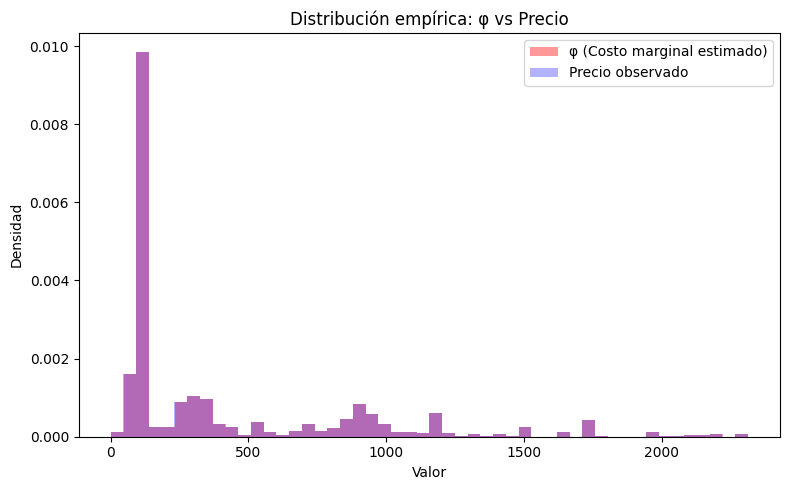

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

phi = pd.to_numeric(df_result2['phi'], errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()
precio = pd.to_numeric(df_result2['precio_d'], errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(8,5))
plt.hist(phi, bins=50, density=True, color="red", alpha=0.4, label="φ (Costo marginal estimado)")
plt.hist(precio, bins=50, density=True, color="blue", alpha=0.3, label="Precio observado")
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.title("Distribución empírica: φ vs Precio")
plt.legend()
plt.tight_layout()
# --- Guardar figura ---
fecha_min = df_result2['Fecha'].min()
fecha_max = df_result2['Fecha'].max()
filename = f"phi_precio_{fecha_min}_to_{fecha_max}_M{M}.png"
filepath = os.path.join(sub_dir, filename)
plt.savefig(filepath, dpi=300)
print(f"✅ Gráfico guardado: {filepath}")
plt.show()


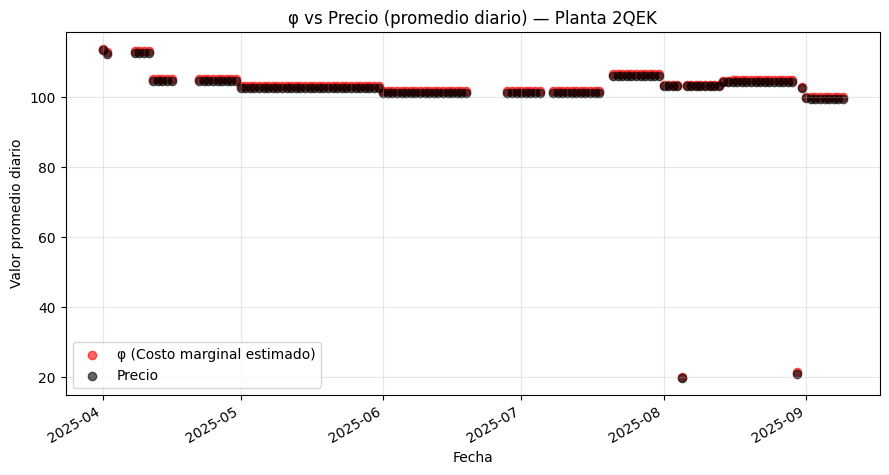

✅ Gráfico guardado: results\fechas_162\phi_precio_2QEK_2025-04-01_to_2025-09-09_M1.png


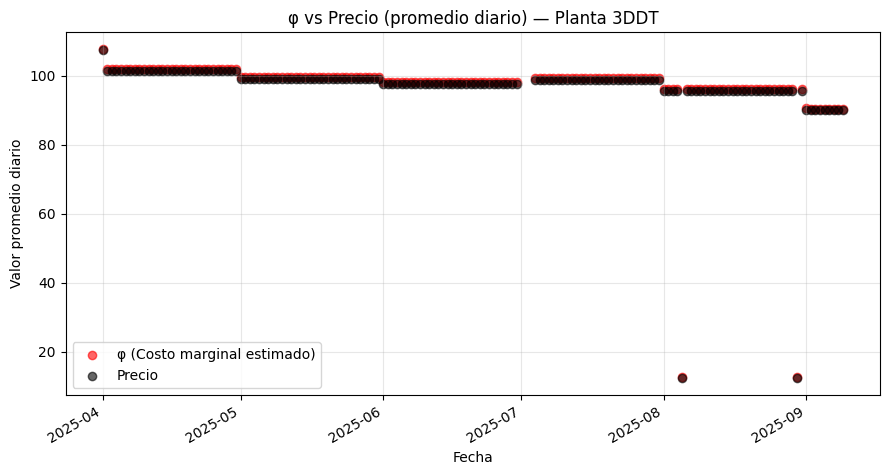

✅ Gráfico guardado: results\fechas_162\phi_precio_3DDT_2025-04-01_to_2025-09-09_M1.png


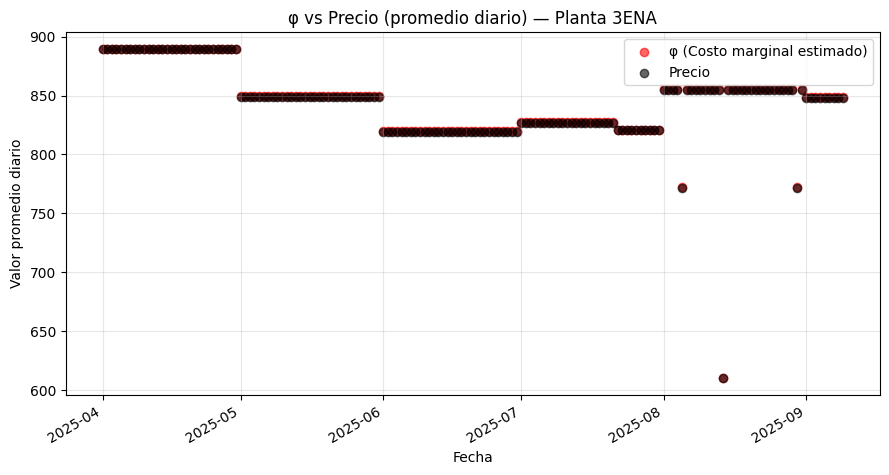

✅ Gráfico guardado: results\fechas_162\phi_precio_3ENA_2025-04-01_to_2025-09-09_M1.png


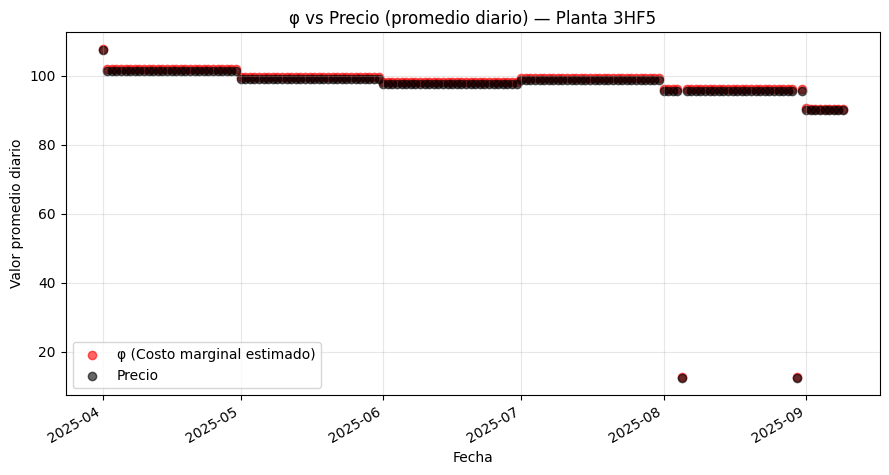

✅ Gráfico guardado: results\fechas_162\phi_precio_3HF5_2025-04-01_to_2025-09-09_M1.png


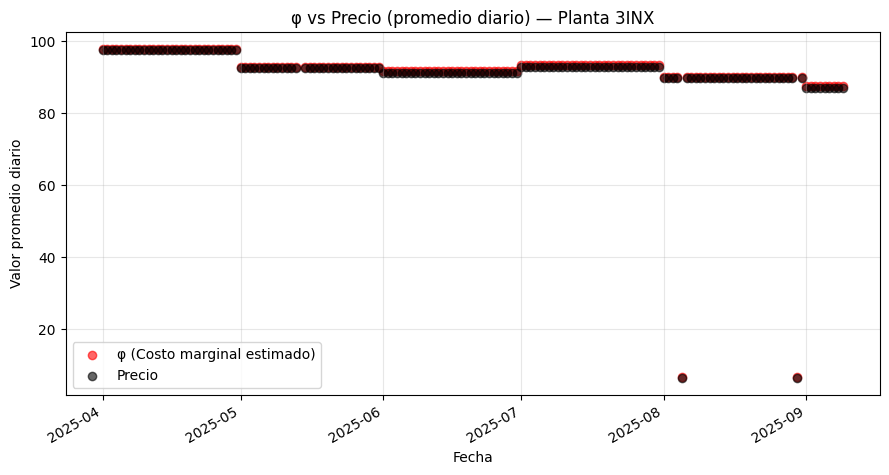

✅ Gráfico guardado: results\fechas_162\phi_precio_3INX_2025-04-01_to_2025-09-09_M1.png


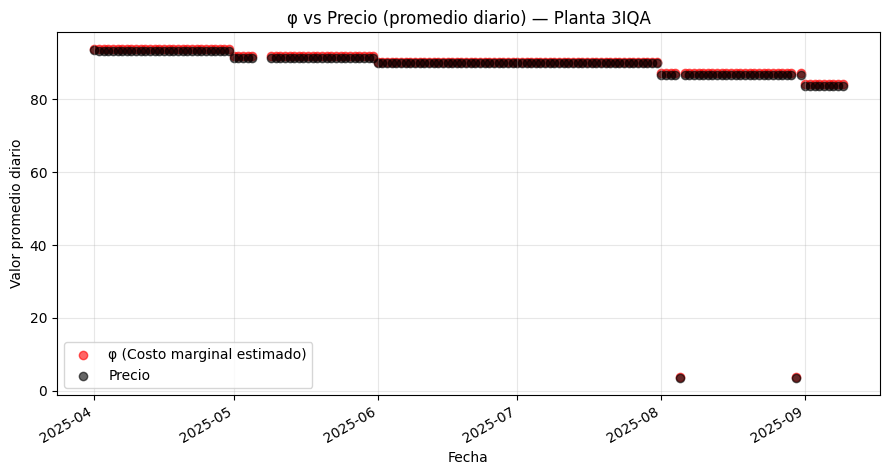

✅ Gráfico guardado: results\fechas_162\phi_precio_3IQA_2025-04-01_to_2025-09-09_M1.png


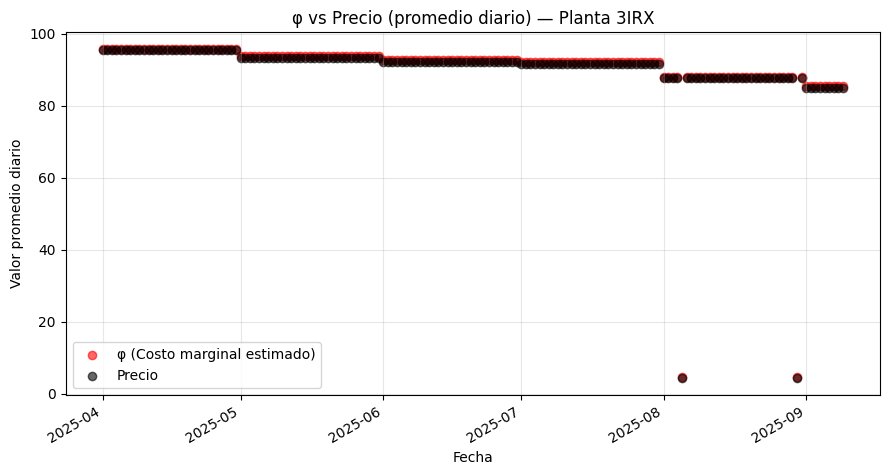

✅ Gráfico guardado: results\fechas_162\phi_precio_3IRX_2025-04-01_to_2025-09-09_M1.png


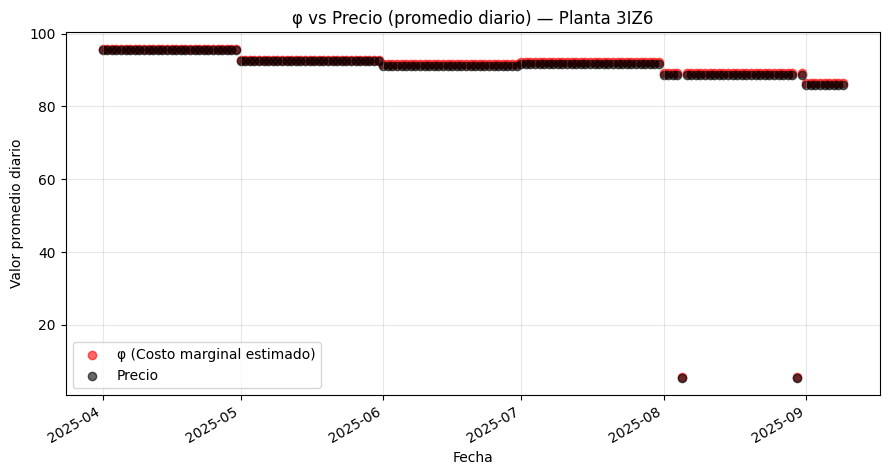

✅ Gráfico guardado: results\fechas_162\phi_precio_3IZ6_2025-04-01_to_2025-09-09_M1.png


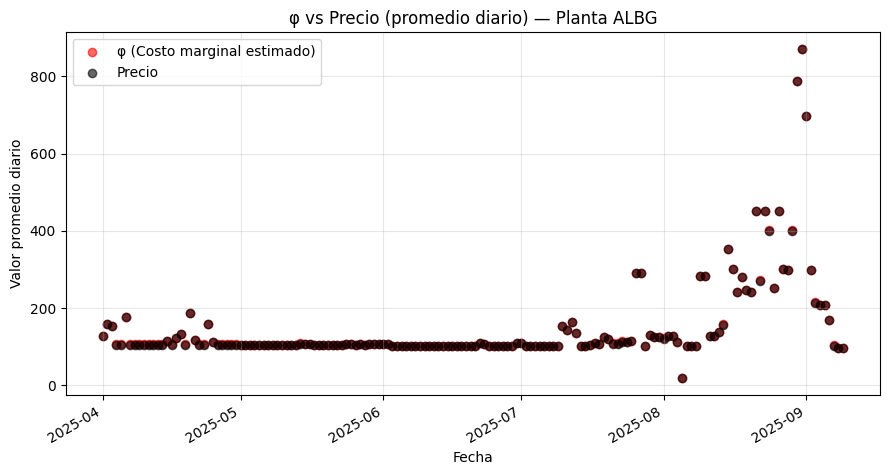

✅ Gráfico guardado: results\fechas_162\phi_precio_ALBG_2025-04-01_to_2025-09-09_M1.png


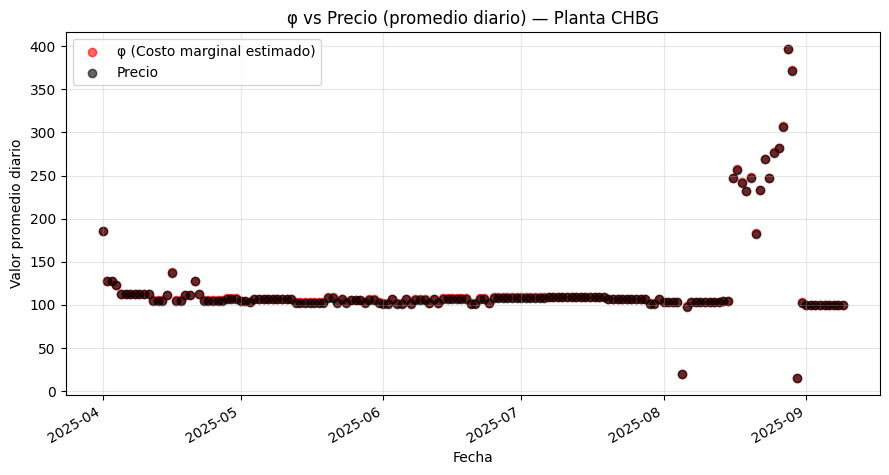

✅ Gráfico guardado: results\fechas_162\phi_precio_CHBG_2025-04-01_to_2025-09-09_M1.png


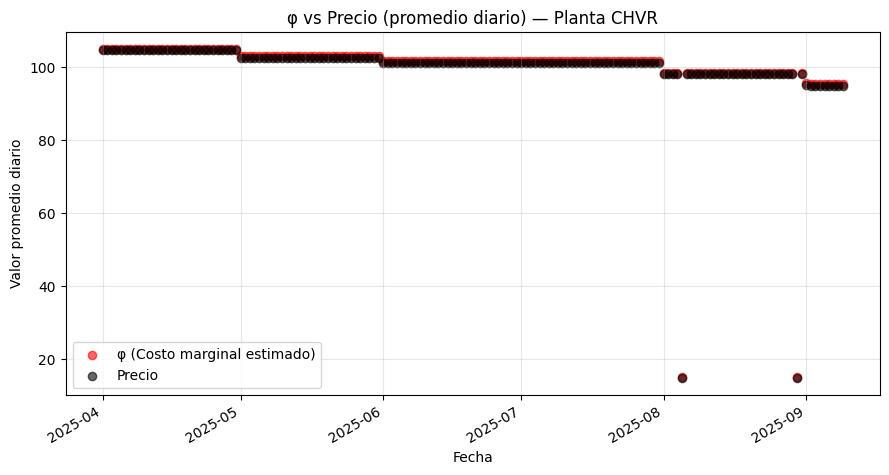

✅ Gráfico guardado: results\fechas_162\phi_precio_CHVR_2025-04-01_to_2025-09-09_M1.png


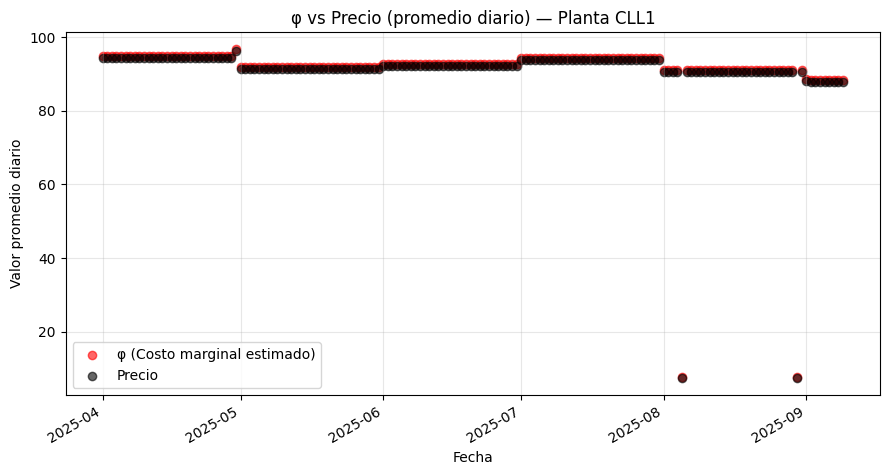

✅ Gráfico guardado: results\fechas_162\phi_precio_CLL1_2025-04-01_to_2025-09-09_M1.png


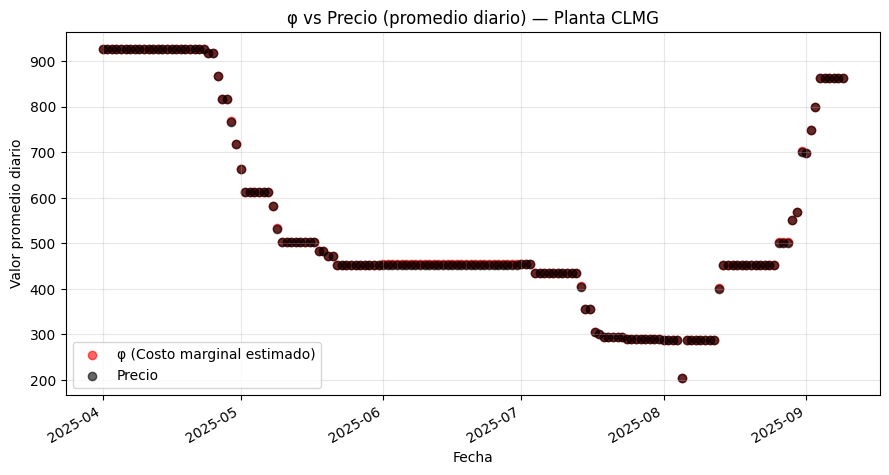

✅ Gráfico guardado: results\fechas_162\phi_precio_CLMG_2025-04-01_to_2025-09-09_M1.png


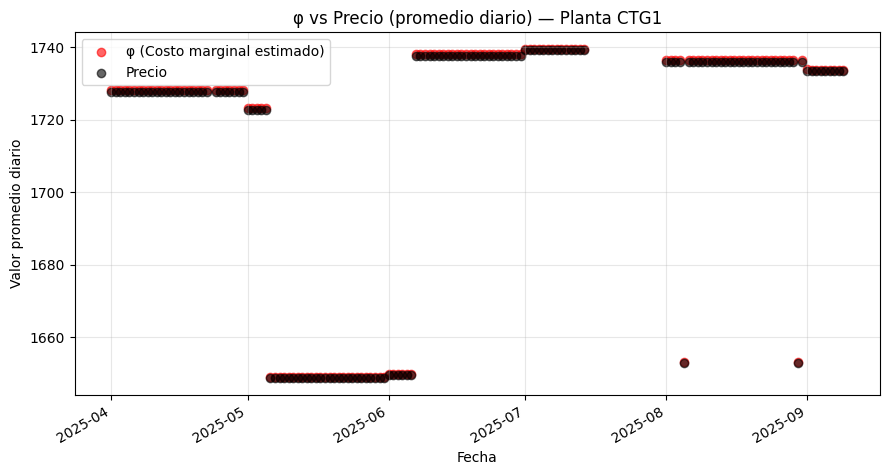

✅ Gráfico guardado: results\fechas_162\phi_precio_CTG1_2025-04-01_to_2025-09-09_M1.png


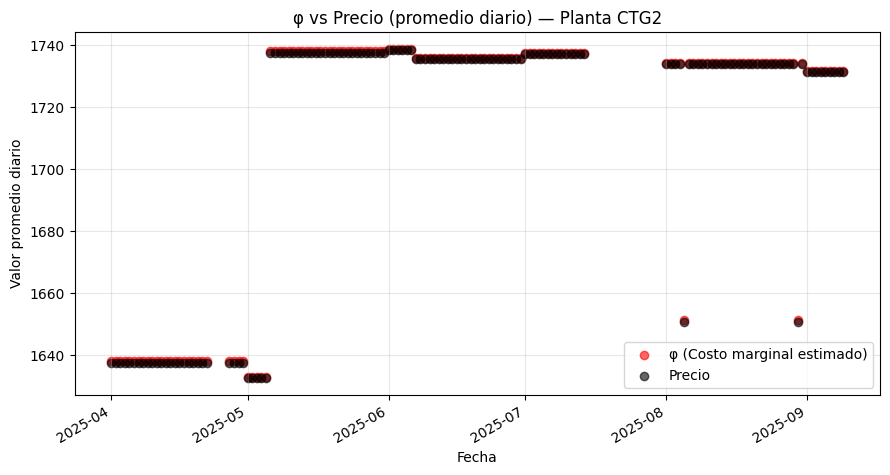

✅ Gráfico guardado: results\fechas_162\phi_precio_CTG2_2025-04-01_to_2025-09-09_M1.png


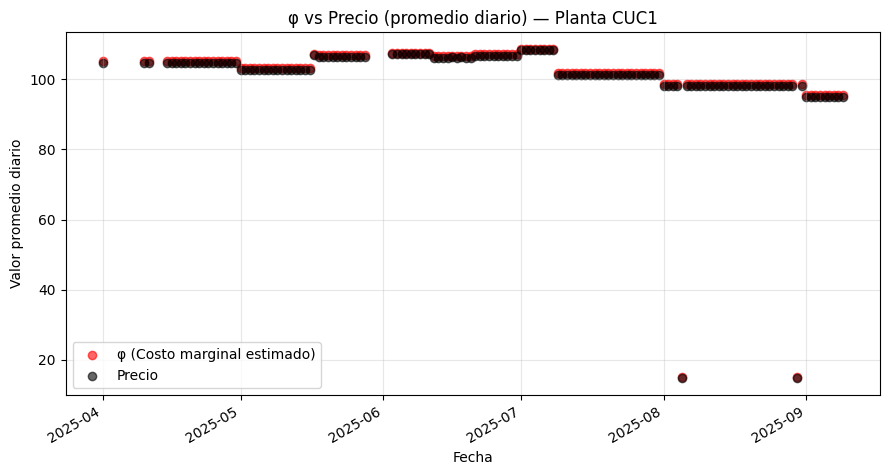

✅ Gráfico guardado: results\fechas_162\phi_precio_CUC1_2025-04-01_to_2025-09-09_M1.png


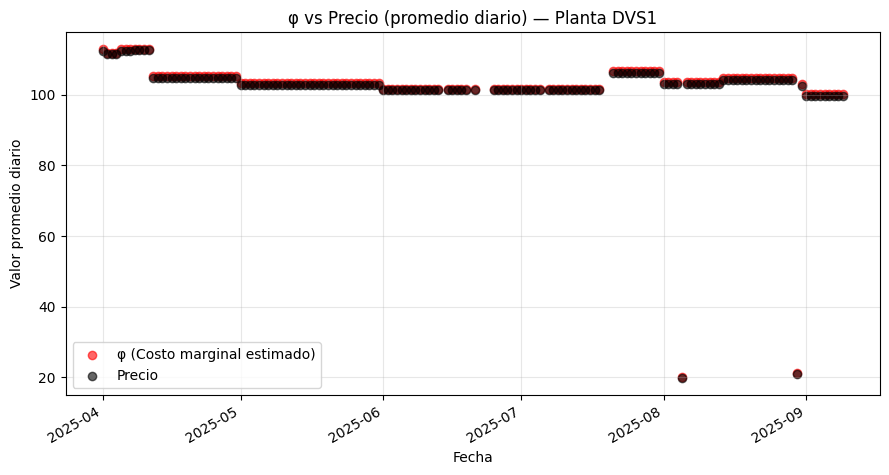

✅ Gráfico guardado: results\fechas_162\phi_precio_DVS1_2025-04-01_to_2025-09-09_M1.png


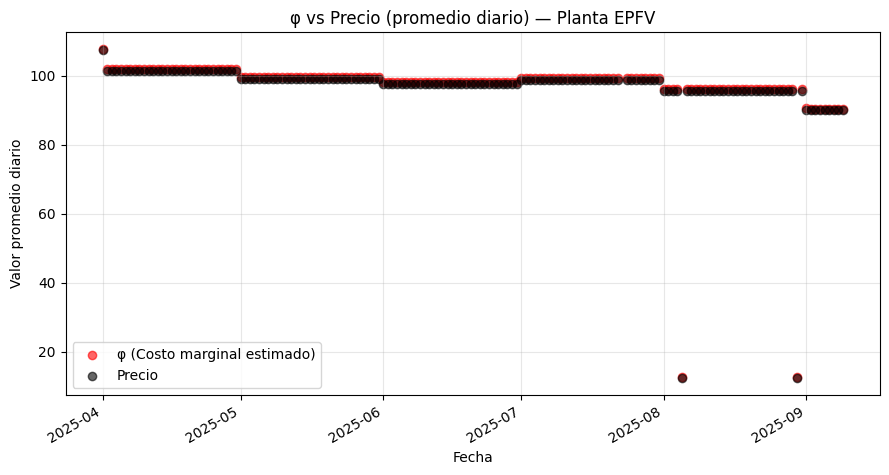

✅ Gráfico guardado: results\fechas_162\phi_precio_EPFV_2025-04-01_to_2025-09-09_M1.png


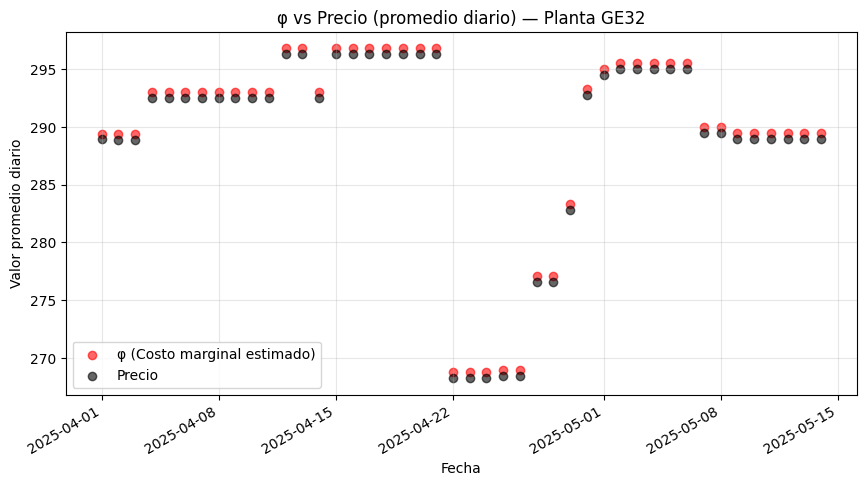

✅ Gráfico guardado: results\fechas_162\phi_precio_GE32_2025-04-01_to_2025-05-14_M1.png


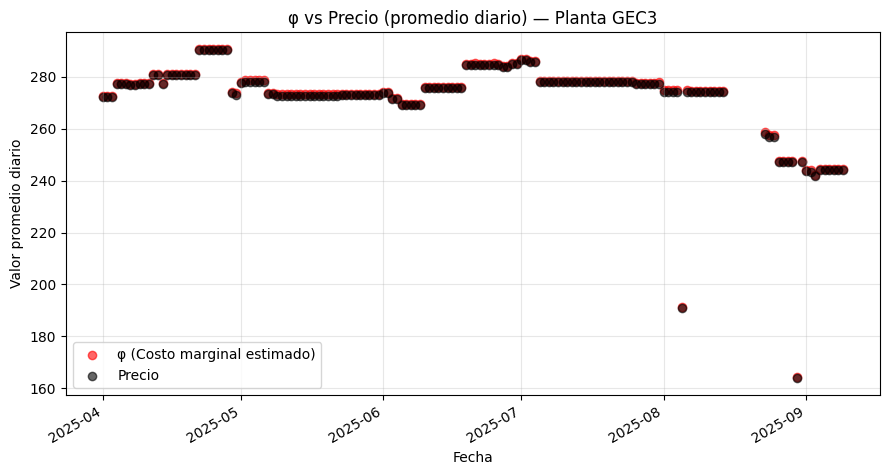

✅ Gráfico guardado: results\fechas_162\phi_precio_GEC3_2025-04-01_to_2025-09-09_M1.png


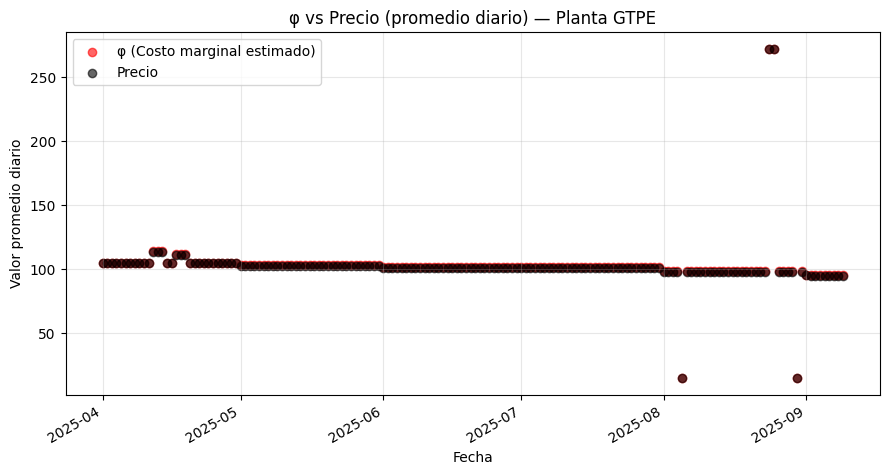

✅ Gráfico guardado: results\fechas_162\phi_precio_GTPE_2025-04-01_to_2025-09-09_M1.png


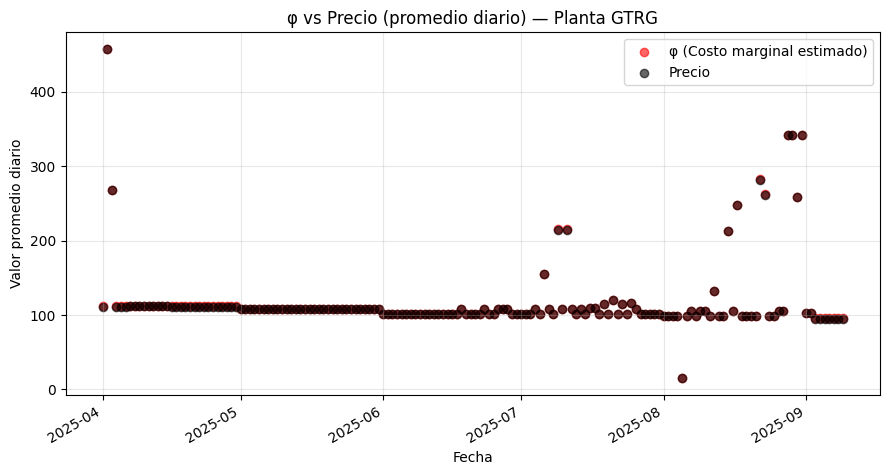

✅ Gráfico guardado: results\fechas_162\phi_precio_GTRG_2025-04-01_to_2025-09-09_M1.png


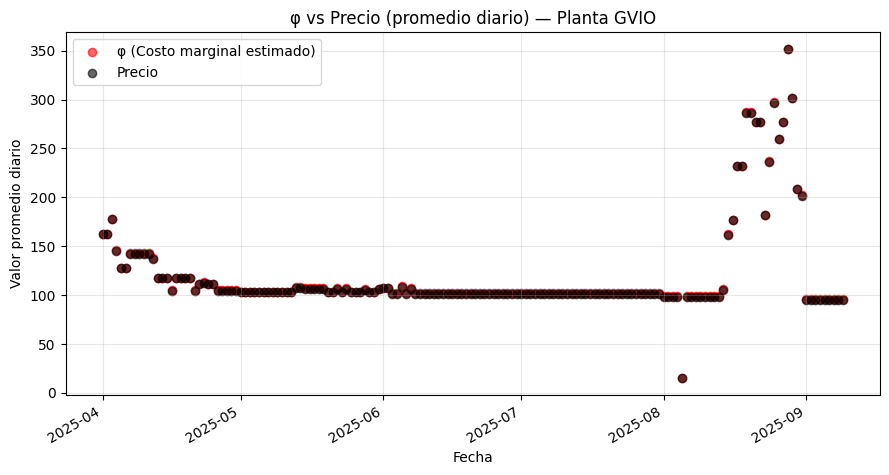

✅ Gráfico guardado: results\fechas_162\phi_precio_GVIO_2025-04-01_to_2025-09-09_M1.png


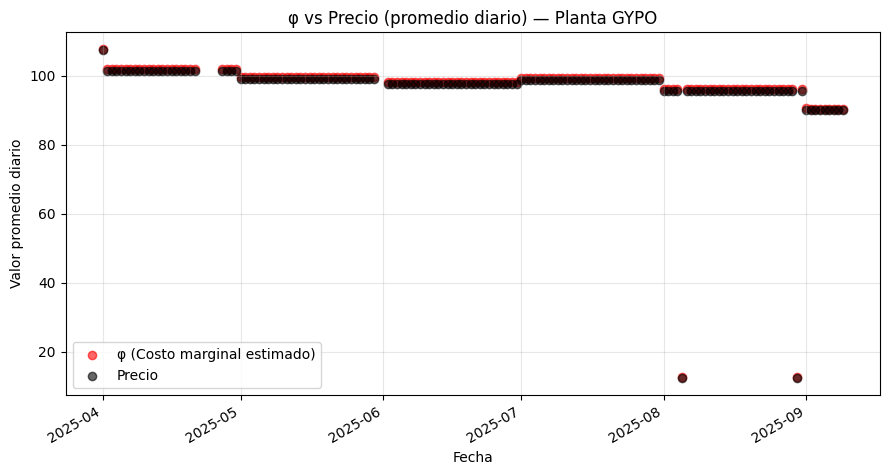

✅ Gráfico guardado: results\fechas_162\phi_precio_GYPO_2025-04-01_to_2025-09-09_M1.png


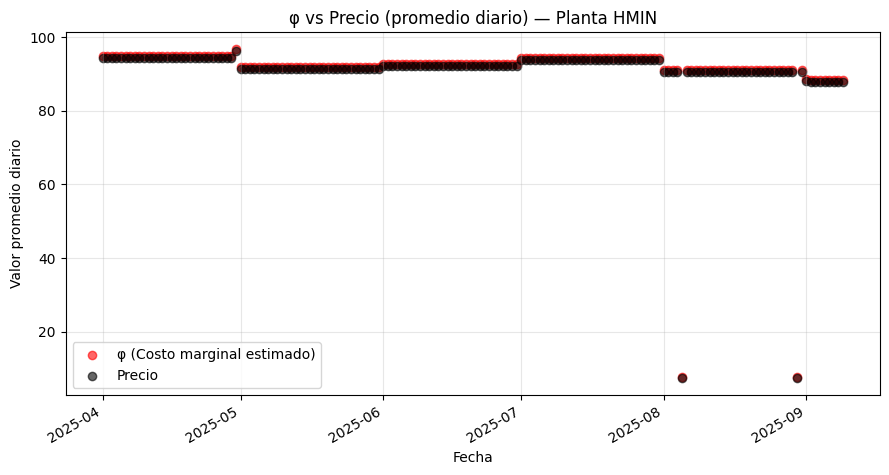

✅ Gráfico guardado: results\fechas_162\phi_precio_HMIN_2025-04-01_to_2025-09-09_M1.png


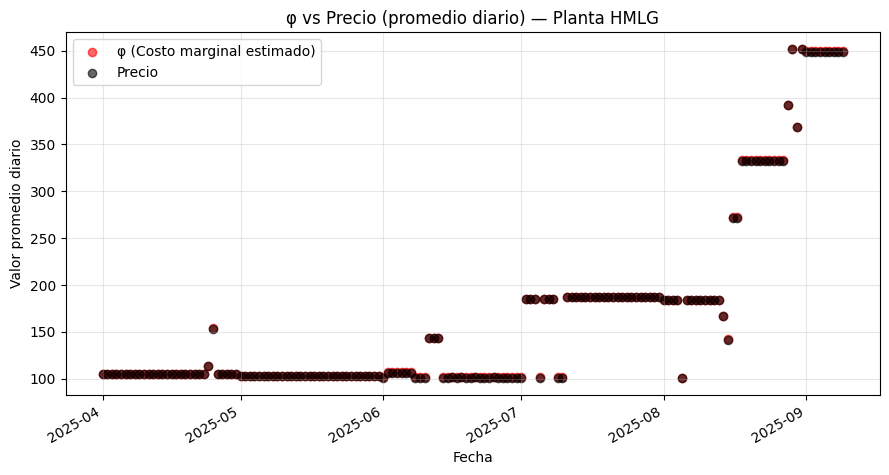

✅ Gráfico guardado: results\fechas_162\phi_precio_HMLG_2025-04-01_to_2025-09-09_M1.png


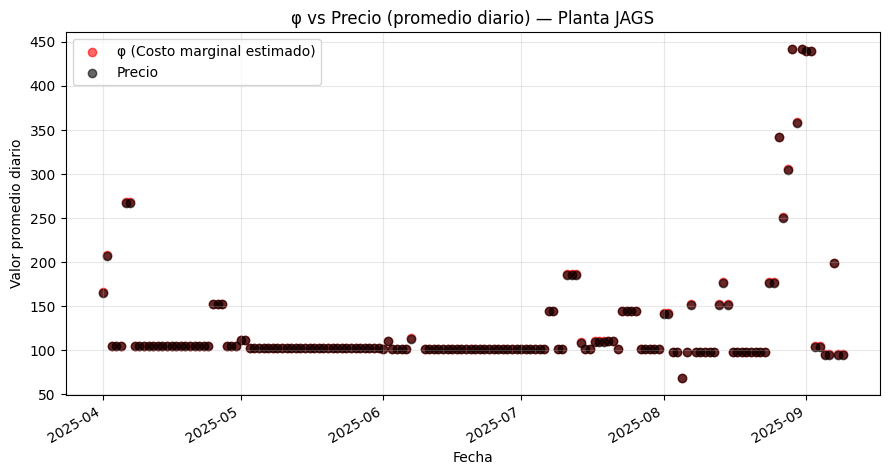

✅ Gráfico guardado: results\fechas_162\phi_precio_JAGS_2025-04-01_to_2025-09-09_M1.png


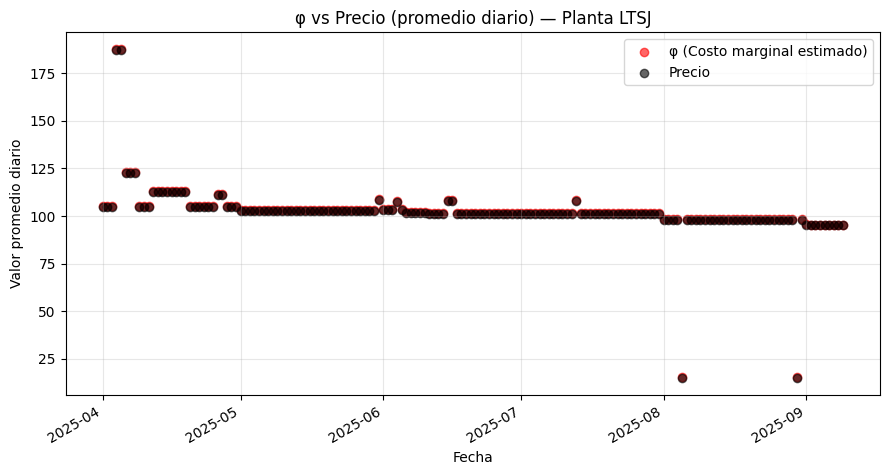

✅ Gráfico guardado: results\fechas_162\phi_precio_LTSJ_2025-04-01_to_2025-09-09_M1.png


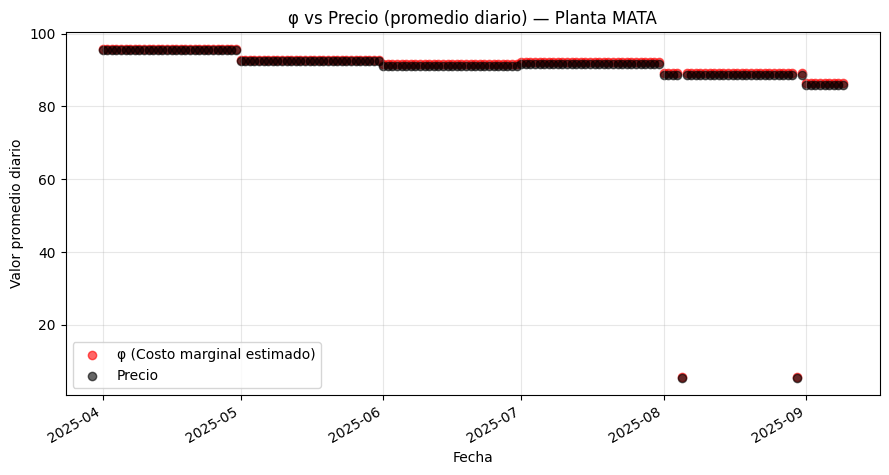

✅ Gráfico guardado: results\fechas_162\phi_precio_MATA_2025-04-01_to_2025-09-09_M1.png


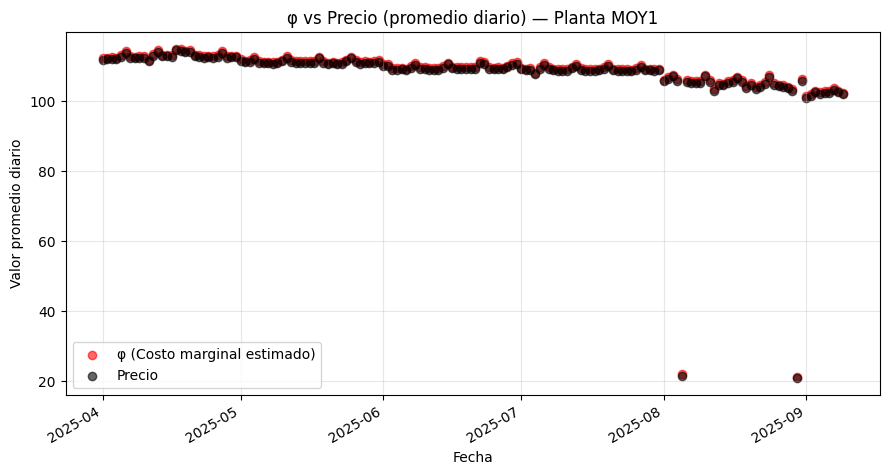

✅ Gráfico guardado: results\fechas_162\phi_precio_MOY1_2025-04-01_to_2025-09-09_M1.png


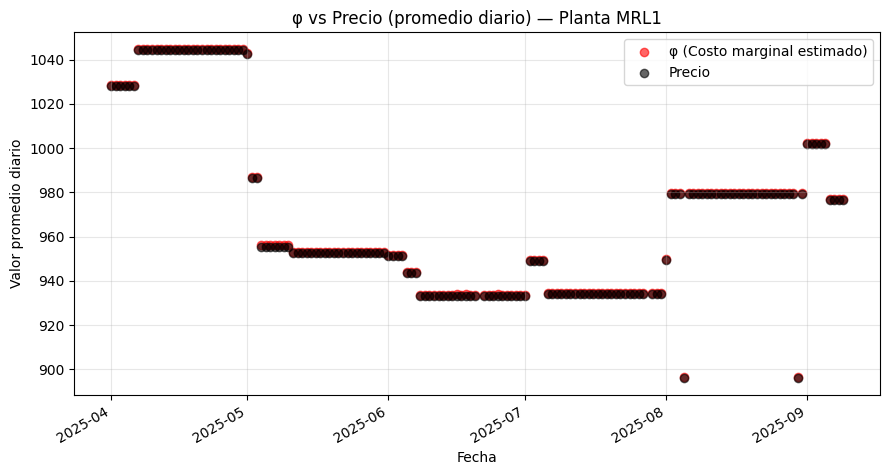

✅ Gráfico guardado: results\fechas_162\phi_precio_MRL1_2025-04-01_to_2025-09-09_M1.png


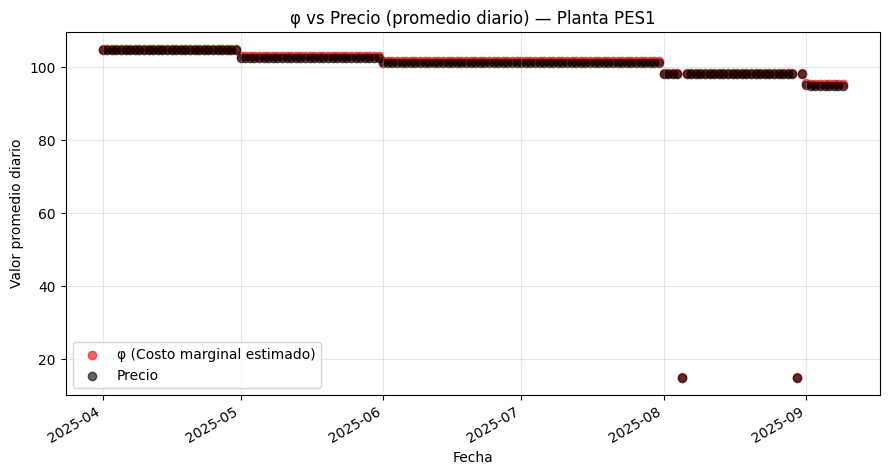

✅ Gráfico guardado: results\fechas_162\phi_precio_PES1_2025-04-01_to_2025-09-09_M1.png


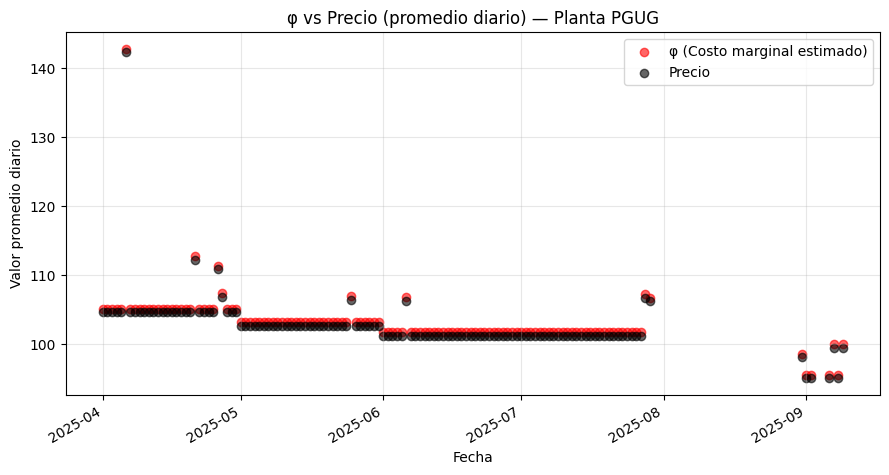

✅ Gráfico guardado: results\fechas_162\phi_precio_PGUG_2025-04-01_to_2025-09-09_M1.png


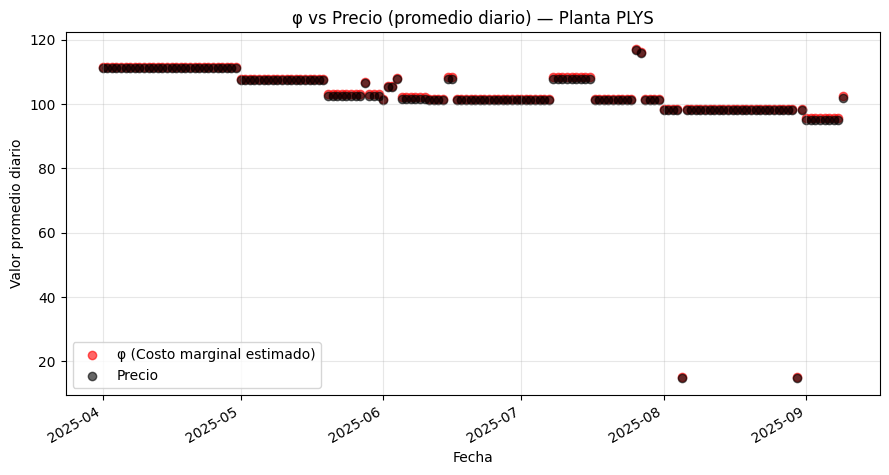

✅ Gráfico guardado: results\fechas_162\phi_precio_PLYS_2025-04-01_to_2025-09-09_M1.png


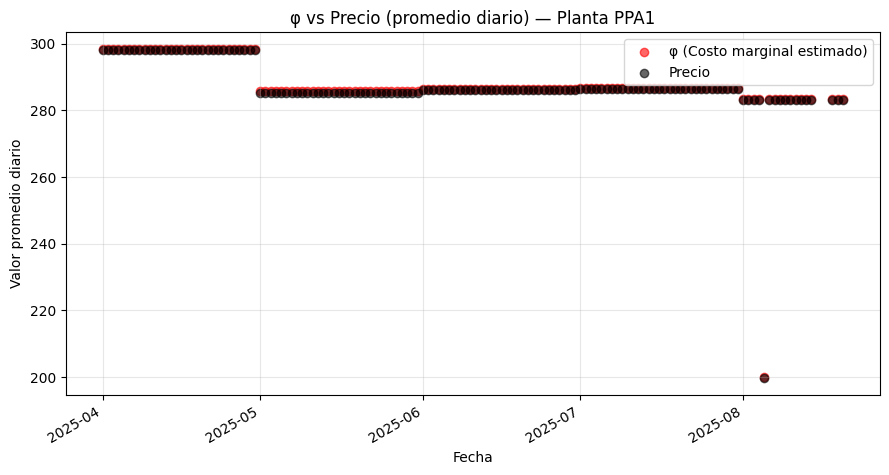

✅ Gráfico guardado: results\fechas_162\phi_precio_PPA1_2025-04-01_to_2025-08-20_M1.png


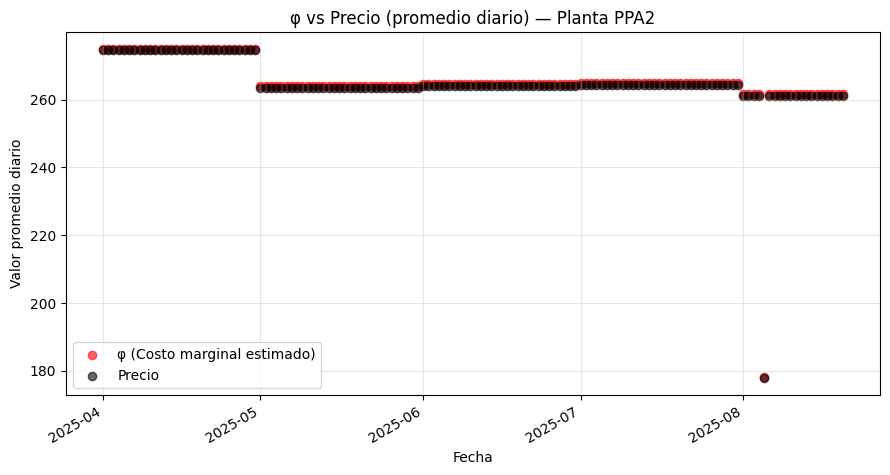

✅ Gráfico guardado: results\fechas_162\phi_precio_PPA2_2025-04-01_to_2025-08-20_M1.png


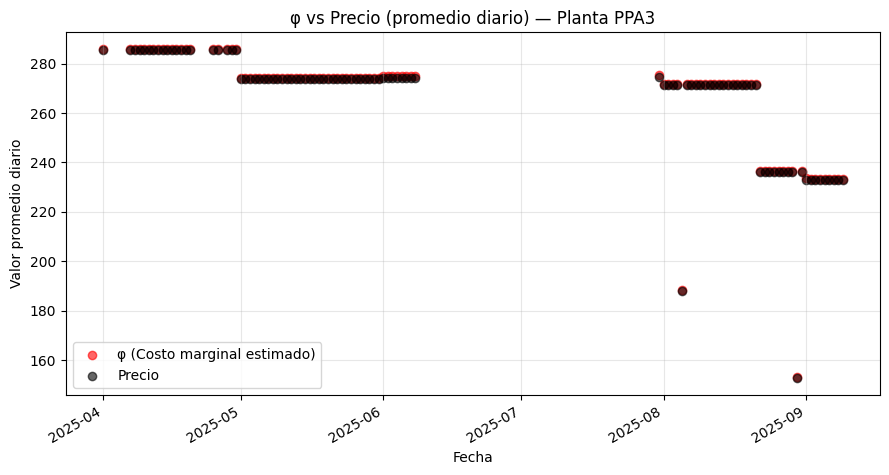

✅ Gráfico guardado: results\fechas_162\phi_precio_PPA3_2025-04-01_to_2025-09-09_M1.png


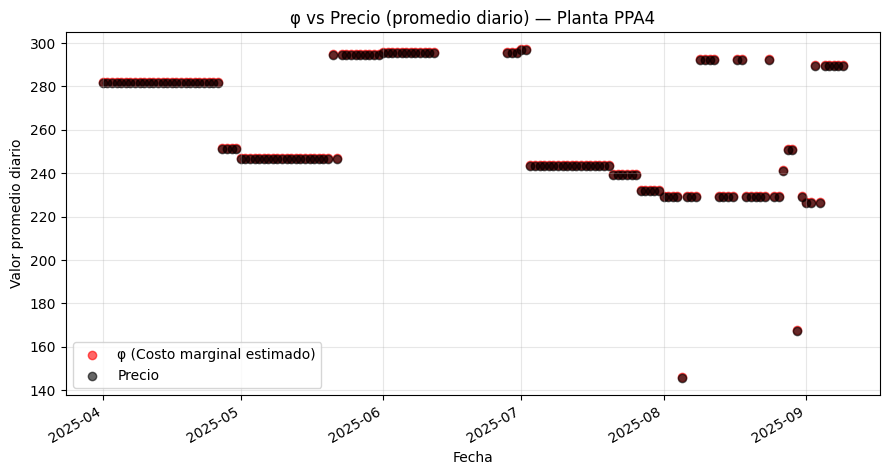

✅ Gráfico guardado: results\fechas_162\phi_precio_PPA4_2025-04-01_to_2025-09-09_M1.png


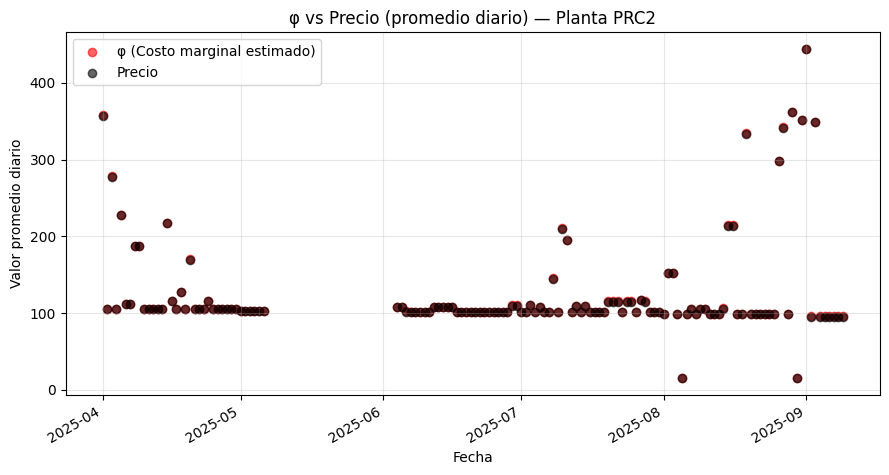

✅ Gráfico guardado: results\fechas_162\phi_precio_PRC2_2025-04-01_to_2025-09-09_M1.png


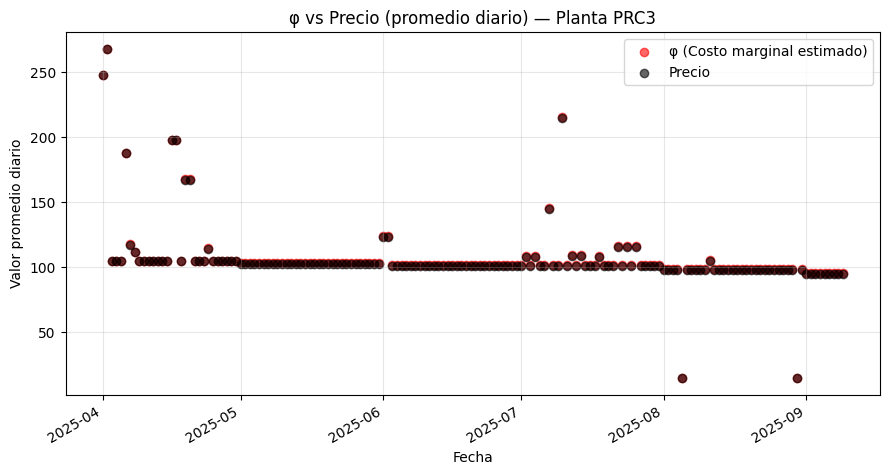

✅ Gráfico guardado: results\fechas_162\phi_precio_PRC3_2025-04-01_to_2025-09-09_M1.png


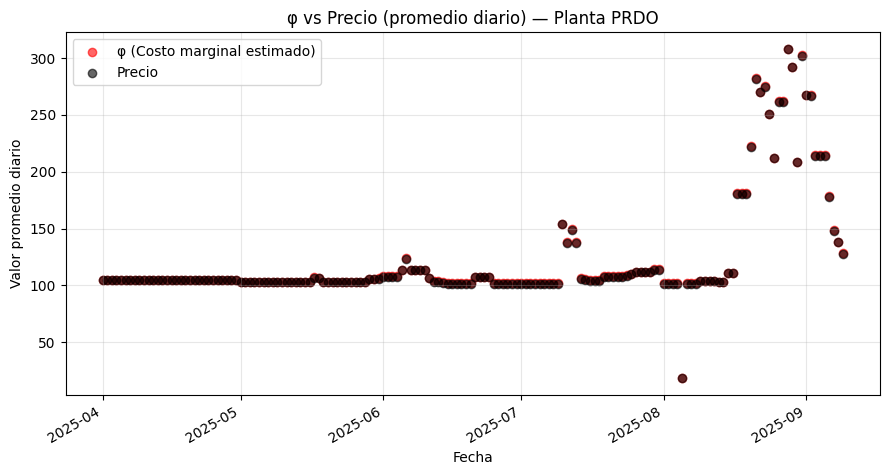

✅ Gráfico guardado: results\fechas_162\phi_precio_PRDO_2025-04-01_to_2025-09-09_M1.png


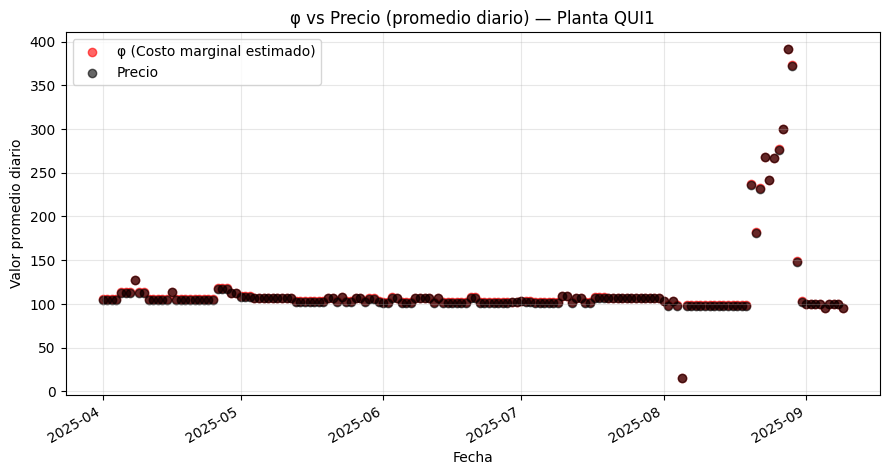

✅ Gráfico guardado: results\fechas_162\phi_precio_QUI1_2025-04-01_to_2025-09-09_M1.png


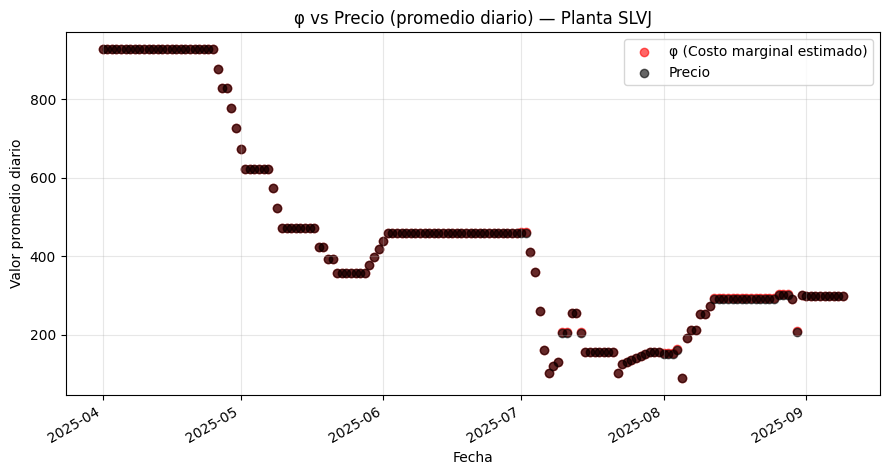

✅ Gráfico guardado: results\fechas_162\phi_precio_SLVJ_2025-04-01_to_2025-09-09_M1.png


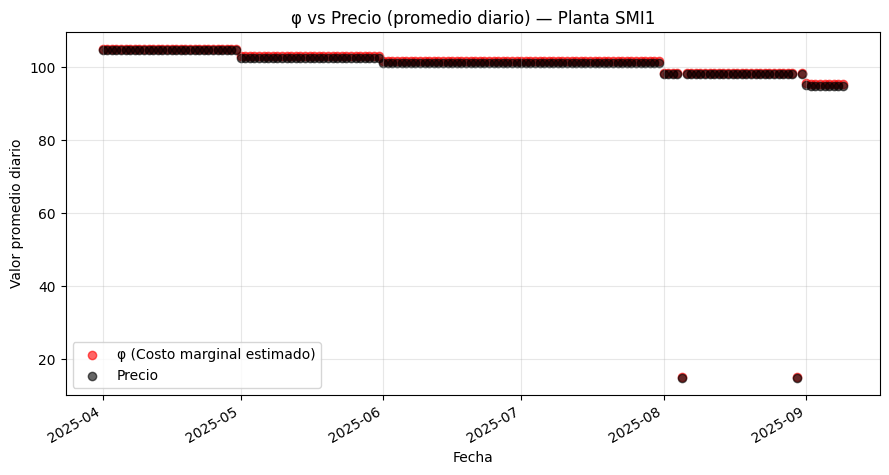

✅ Gráfico guardado: results\fechas_162\phi_precio_SMI1_2025-04-01_to_2025-09-09_M1.png


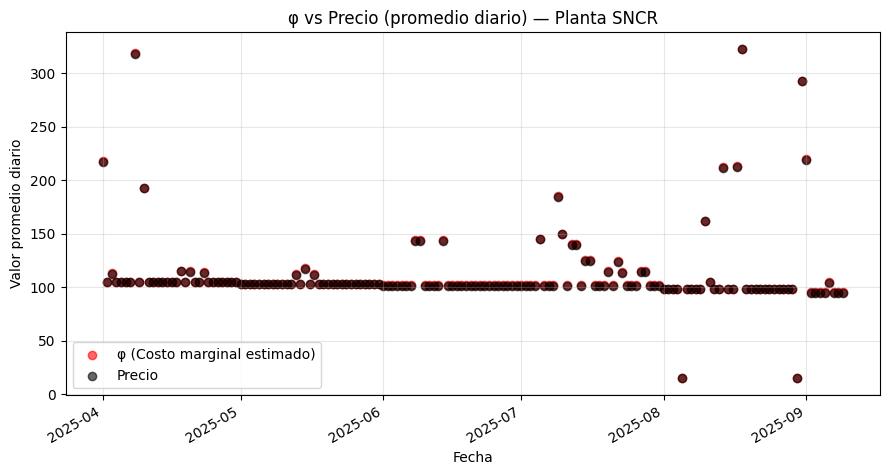

✅ Gráfico guardado: results\fechas_162\phi_precio_SNCR_2025-04-01_to_2025-09-09_M1.png


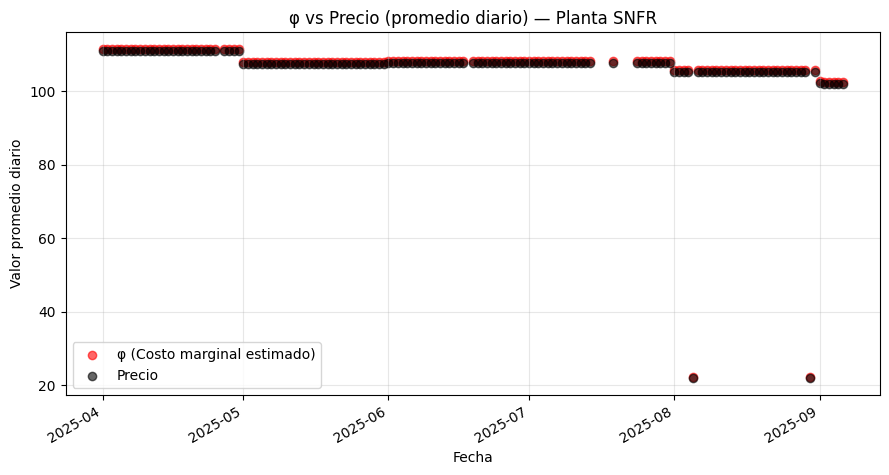

✅ Gráfico guardado: results\fechas_162\phi_precio_SNFR_2025-04-01_to_2025-09-06_M1.png


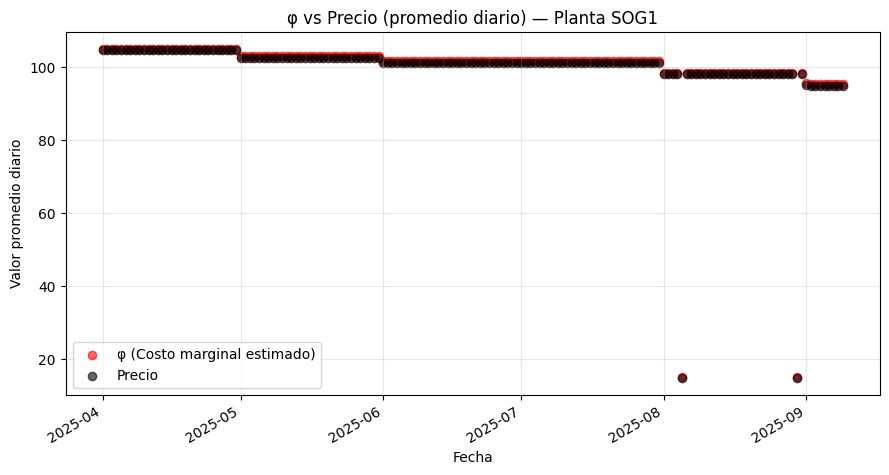

✅ Gráfico guardado: results\fechas_162\phi_precio_SOG1_2025-04-01_to_2025-09-09_M1.png


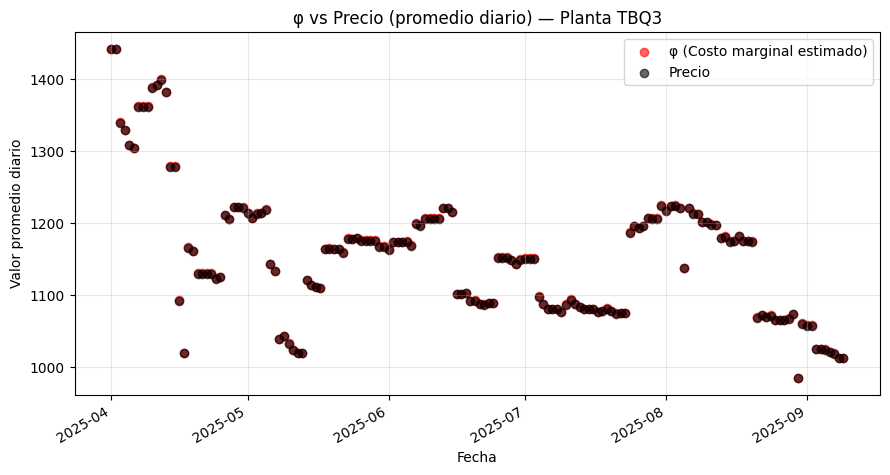

✅ Gráfico guardado: results\fechas_162\phi_precio_TBQ3_2025-04-01_to_2025-09-09_M1.png


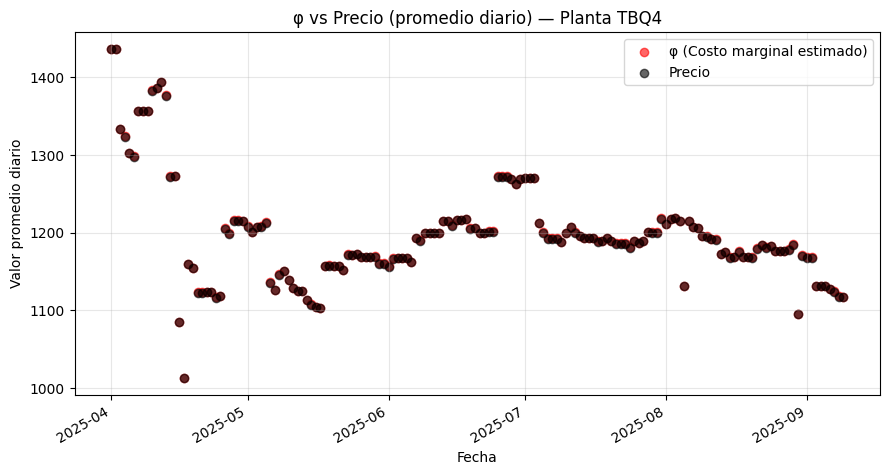

✅ Gráfico guardado: results\fechas_162\phi_precio_TBQ4_2025-04-01_to_2025-09-09_M1.png


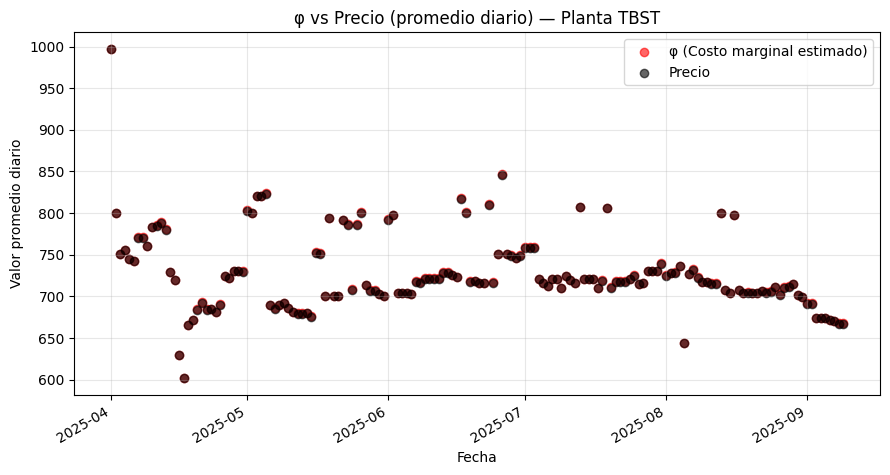

✅ Gráfico guardado: results\fechas_162\phi_precio_TBST_2025-04-01_to_2025-09-09_M1.png


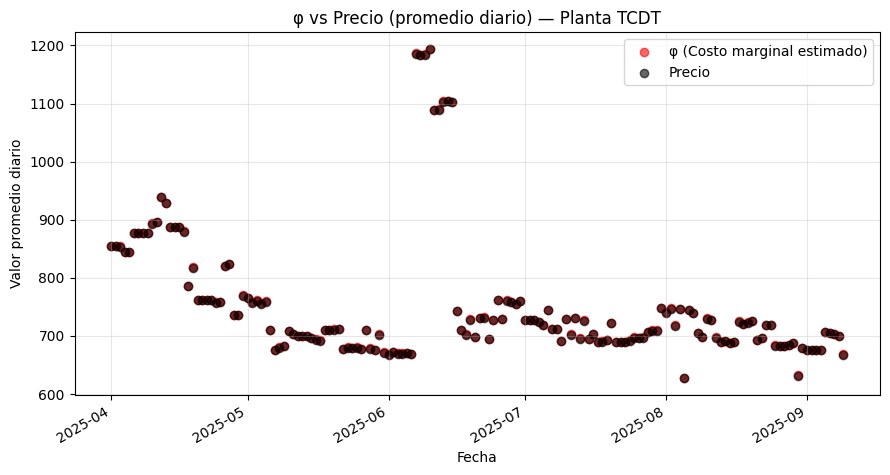

✅ Gráfico guardado: results\fechas_162\phi_precio_TCDT_2025-04-01_to_2025-09-09_M1.png


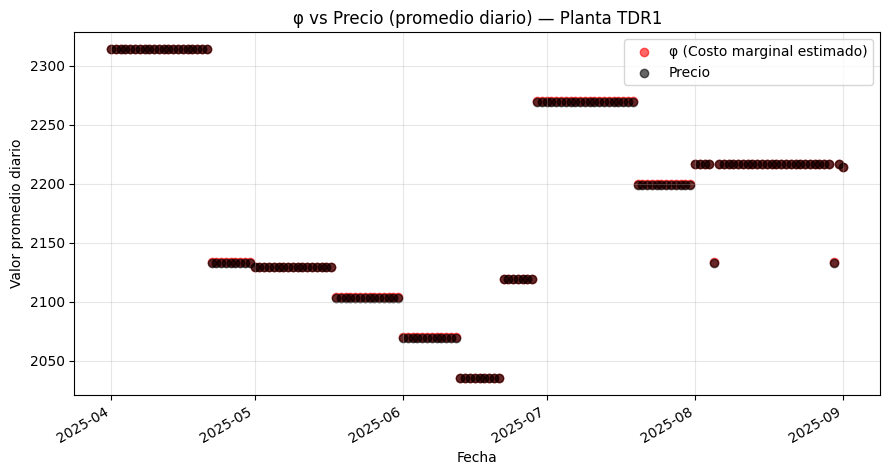

✅ Gráfico guardado: results\fechas_162\phi_precio_TDR1_2025-04-01_to_2025-09-01_M1.png


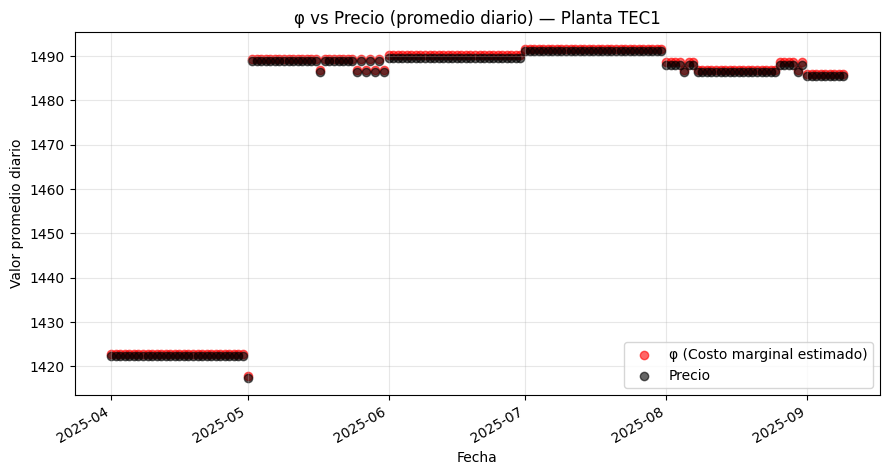

✅ Gráfico guardado: results\fechas_162\phi_precio_TEC1_2025-04-01_to_2025-09-09_M1.png


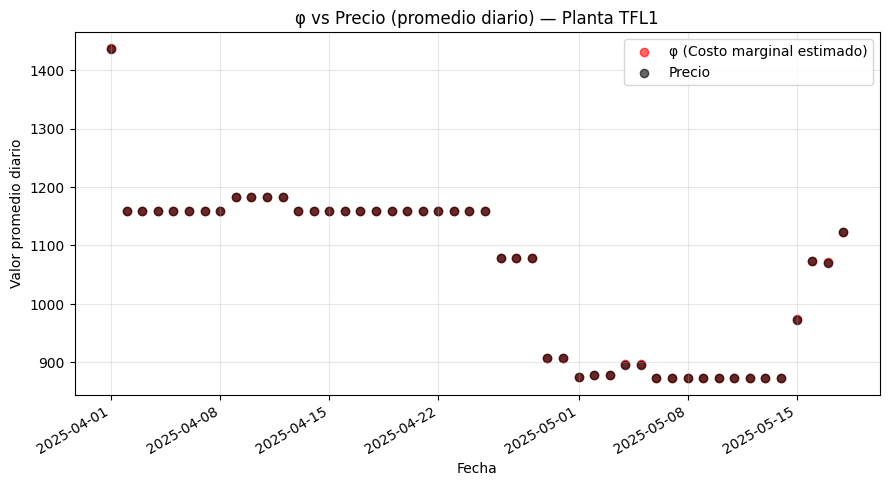

✅ Gráfico guardado: results\fechas_162\phi_precio_TFL1_2025-04-01_to_2025-05-18_M1.png


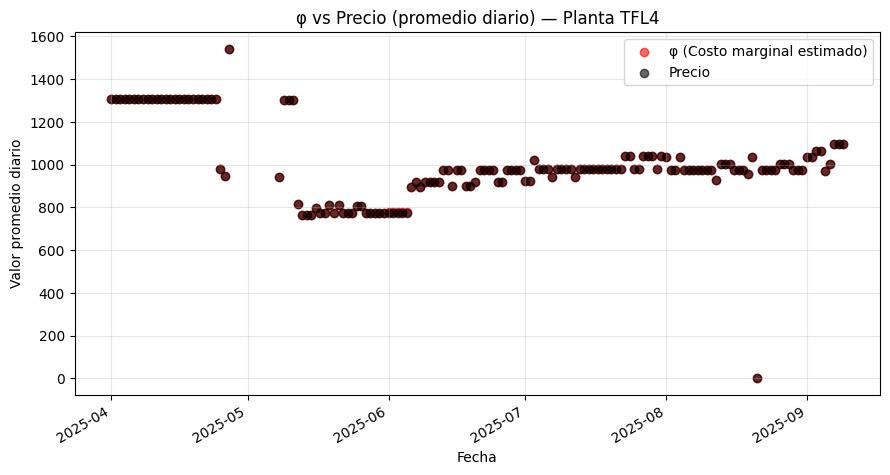

✅ Gráfico guardado: results\fechas_162\phi_precio_TFL4_2025-04-01_to_2025-09-09_M1.png


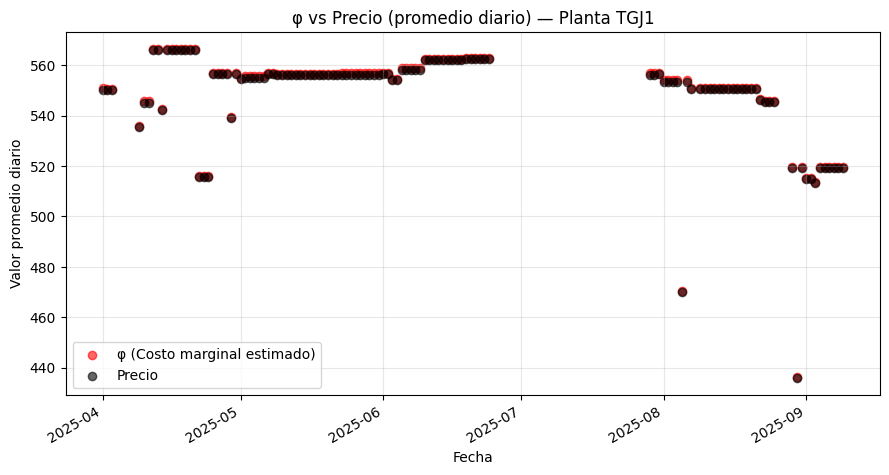

✅ Gráfico guardado: results\fechas_162\phi_precio_TGJ1_2025-04-01_to_2025-09-09_M1.png


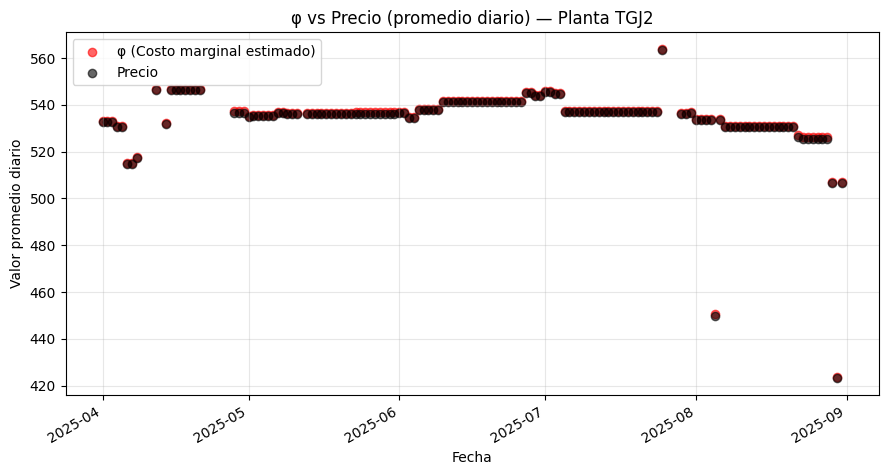

✅ Gráfico guardado: results\fechas_162\phi_precio_TGJ2_2025-04-01_to_2025-08-31_M1.png


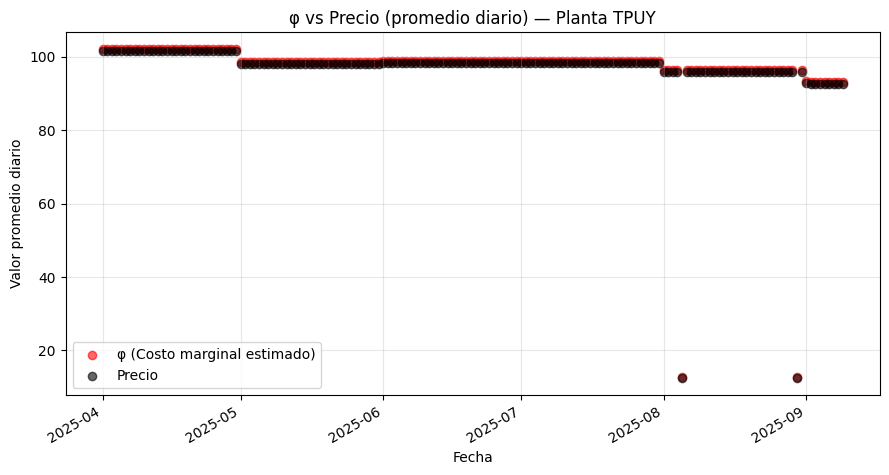

✅ Gráfico guardado: results\fechas_162\phi_precio_TPUY_2025-04-01_to_2025-09-09_M1.png


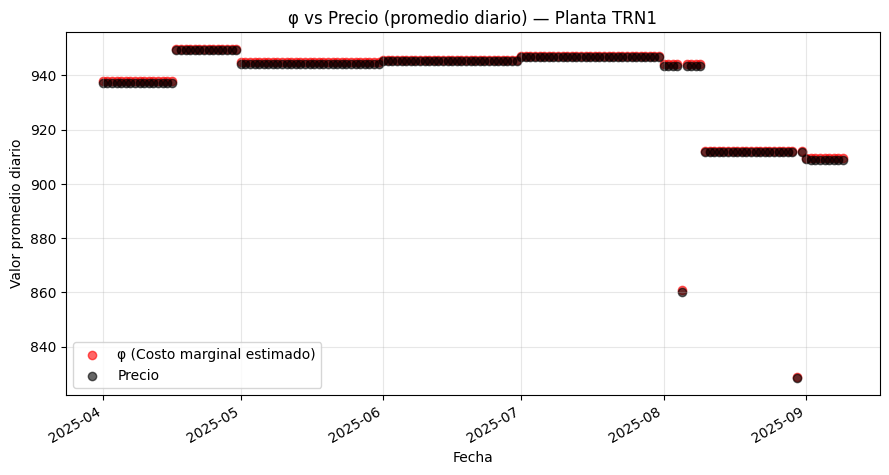

✅ Gráfico guardado: results\fechas_162\phi_precio_TRN1_2025-04-01_to_2025-09-09_M1.png


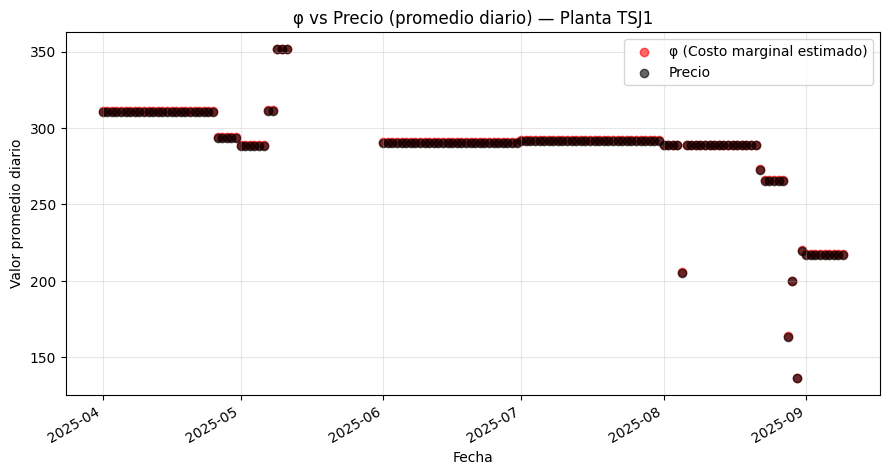

✅ Gráfico guardado: results\fechas_162\phi_precio_TSJ1_2025-04-01_to_2025-09-09_M1.png


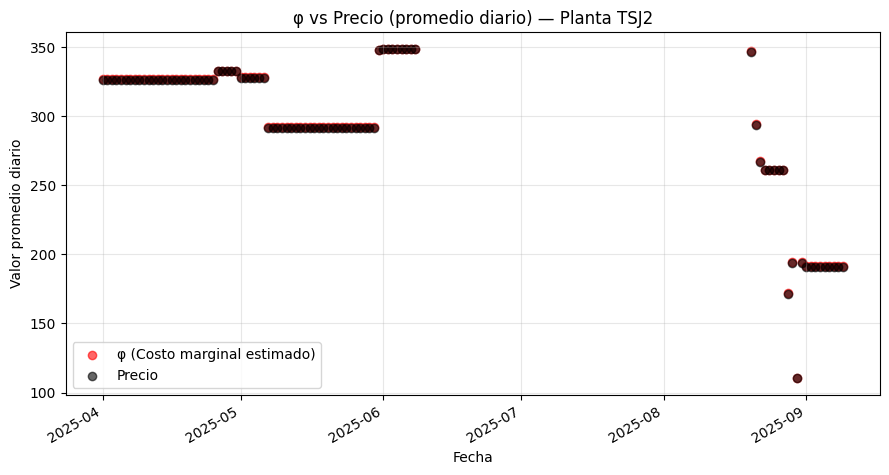

✅ Gráfico guardado: results\fechas_162\phi_precio_TSJ2_2025-04-01_to_2025-09-09_M1.png


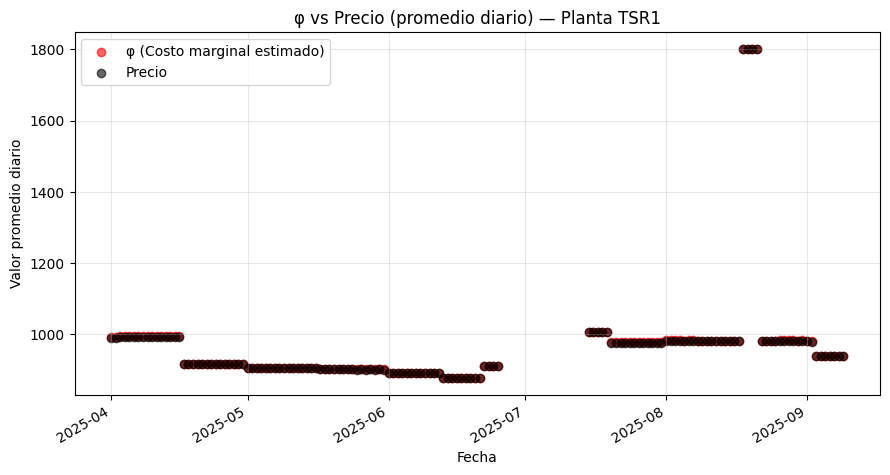

✅ Gráfico guardado: results\fechas_162\phi_precio_TSR1_2025-04-01_to_2025-09-09_M1.png


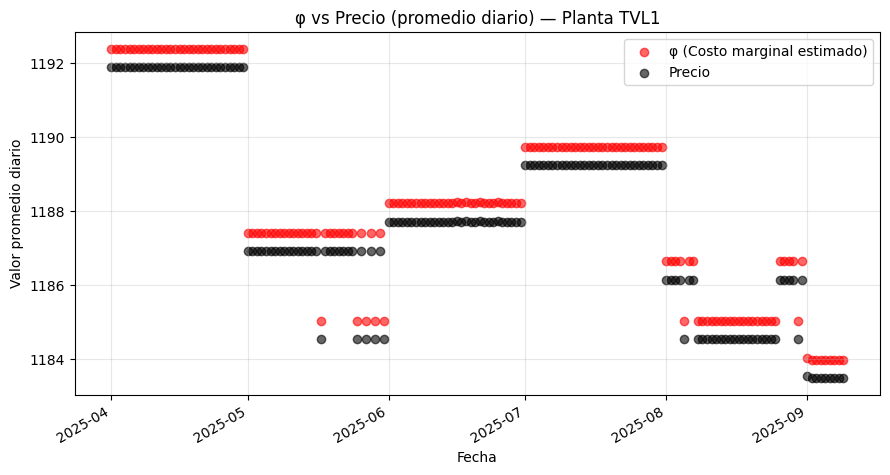

✅ Gráfico guardado: results\fechas_162\phi_precio_TVL1_2025-04-01_to_2025-09-09_M1.png


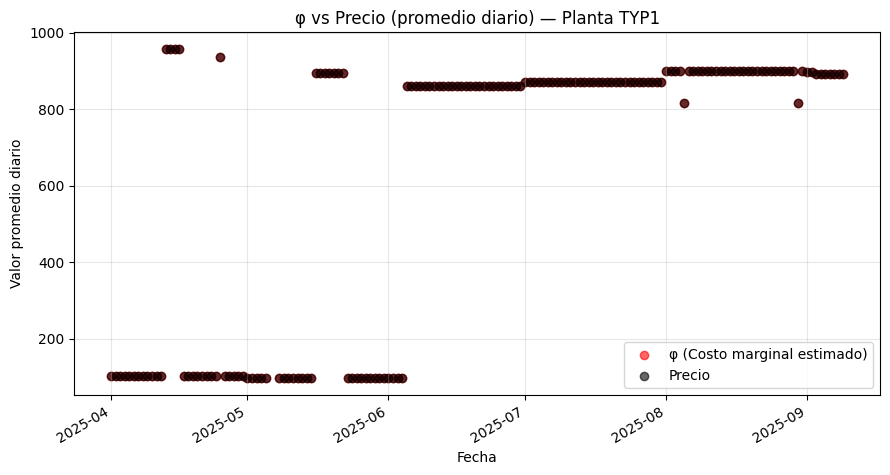

✅ Gráfico guardado: results\fechas_162\phi_precio_TYP1_2025-04-01_to_2025-09-09_M1.png


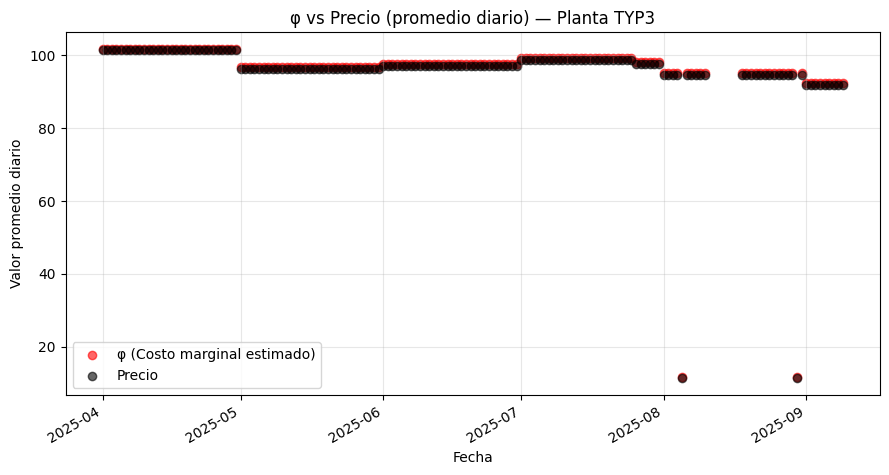

✅ Gráfico guardado: results\fechas_162\phi_precio_TYP3_2025-04-01_to_2025-09-09_M1.png


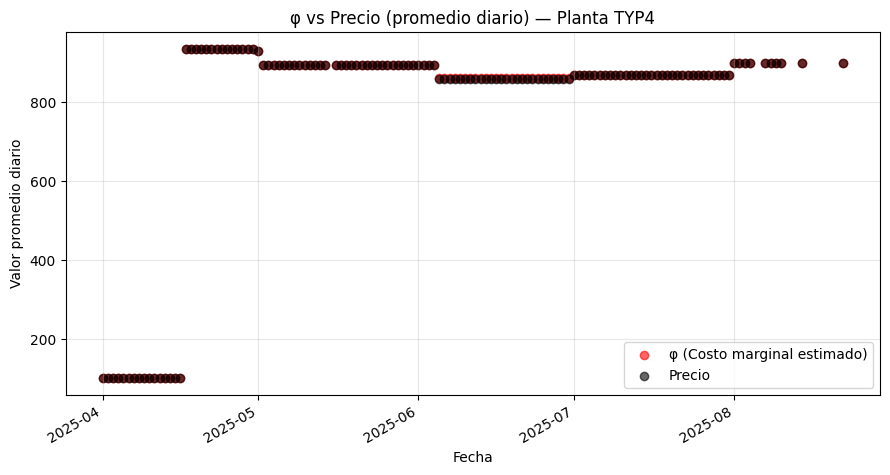

✅ Gráfico guardado: results\fechas_162\phi_precio_TYP4_2025-04-01_to_2025-08-22_M1.png


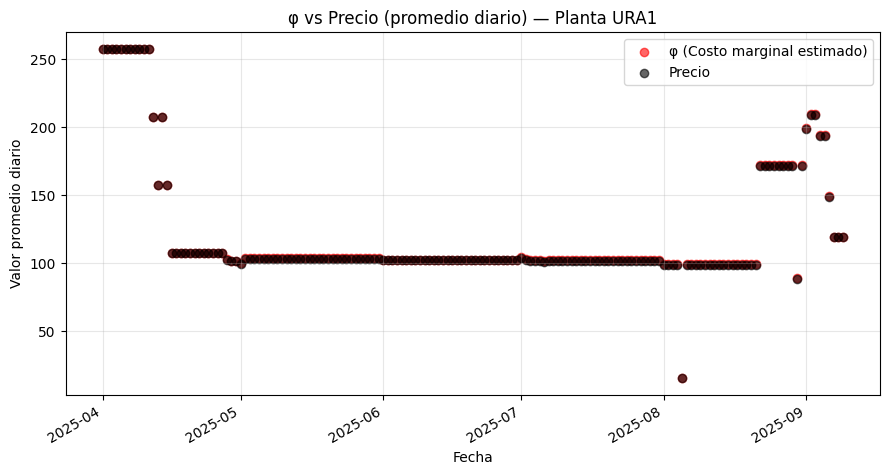

✅ Gráfico guardado: results\fechas_162\phi_precio_URA1_2025-04-01_to_2025-09-09_M1.png


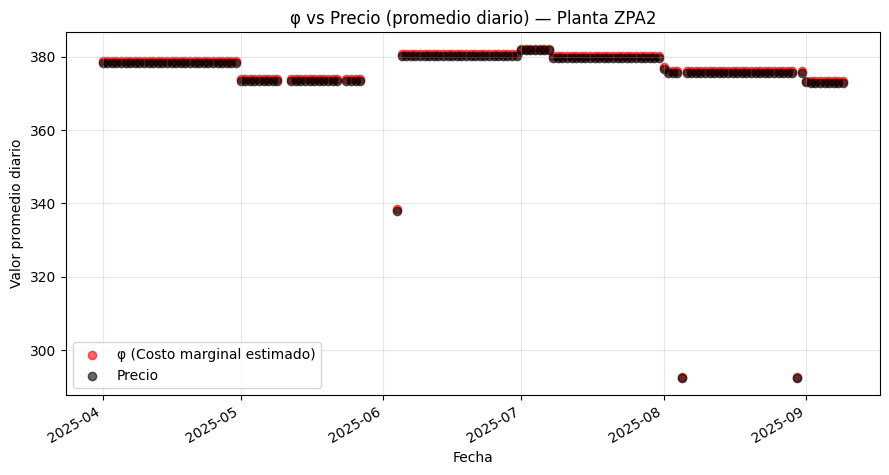

✅ Gráfico guardado: results\fechas_162\phi_precio_ZPA2_2025-04-01_to_2025-09-09_M1.png


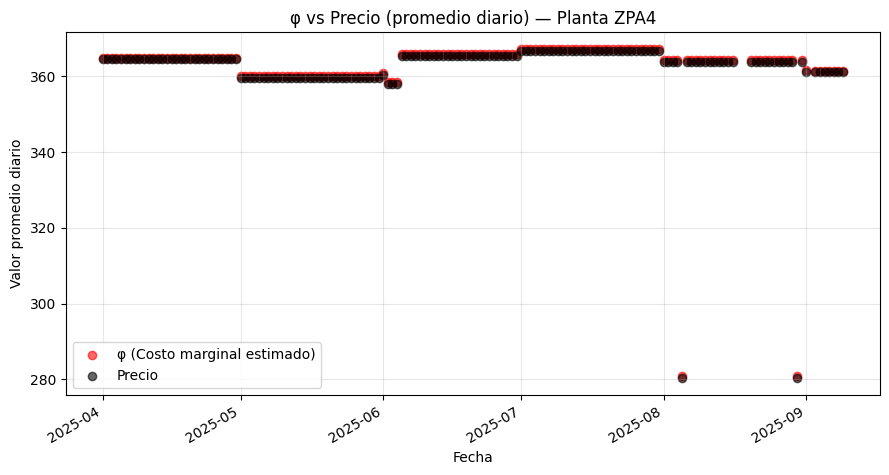

✅ Gráfico guardado: results\fechas_162\phi_precio_ZPA4_2025-04-01_to_2025-09-09_M1.png


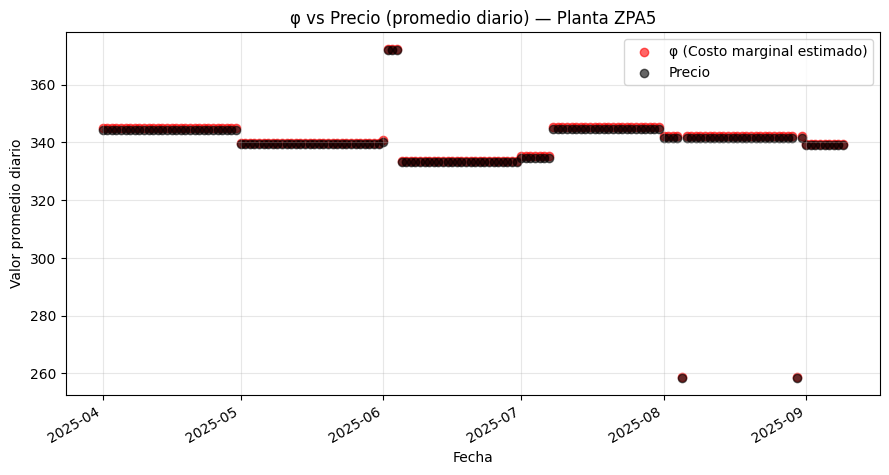

✅ Gráfico guardado: results\fechas_162\phi_precio_ZPA5_2025-04-01_to_2025-09-09_M1.png


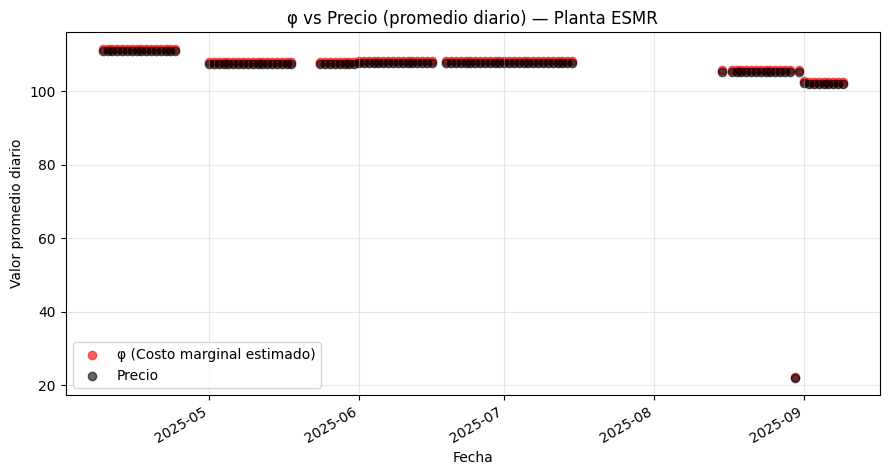

✅ Gráfico guardado: results\fechas_162\phi_precio_ESMR_2025-04-09_to_2025-09-09_M1.png


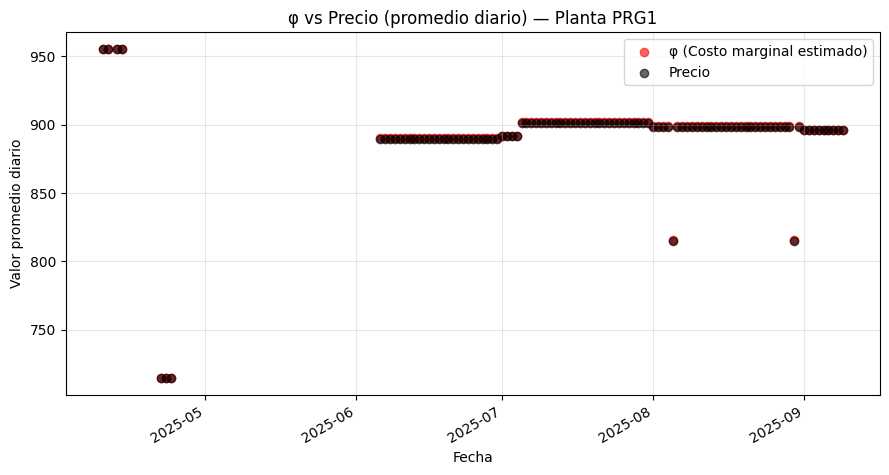

✅ Gráfico guardado: results\fechas_162\phi_precio_PRG1_2025-04-10_to_2025-09-09_M1.png


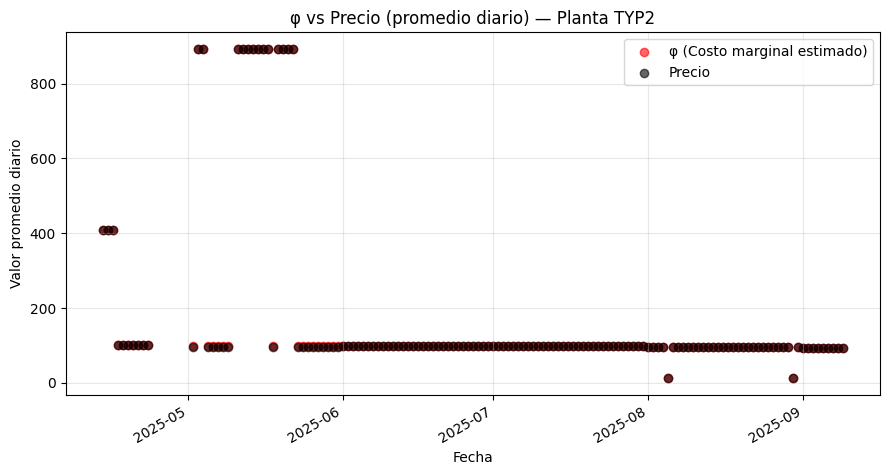

✅ Gráfico guardado: results\fechas_162\phi_precio_TYP2_2025-04-14_to_2025-09-09_M1.png


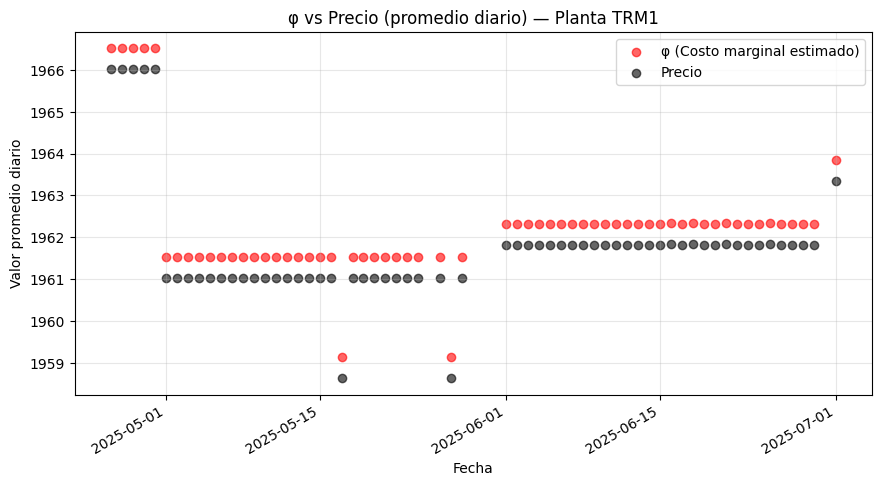

✅ Gráfico guardado: results\fechas_162\phi_precio_TRM1_2025-04-26_to_2025-07-01_M1.png


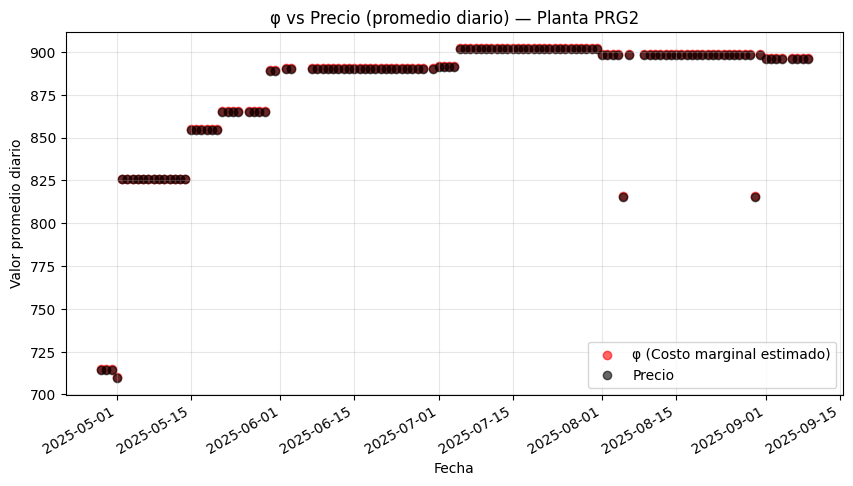

✅ Gráfico guardado: results\fechas_162\phi_precio_PRG2_2025-04-28_to_2025-09-09_M1.png


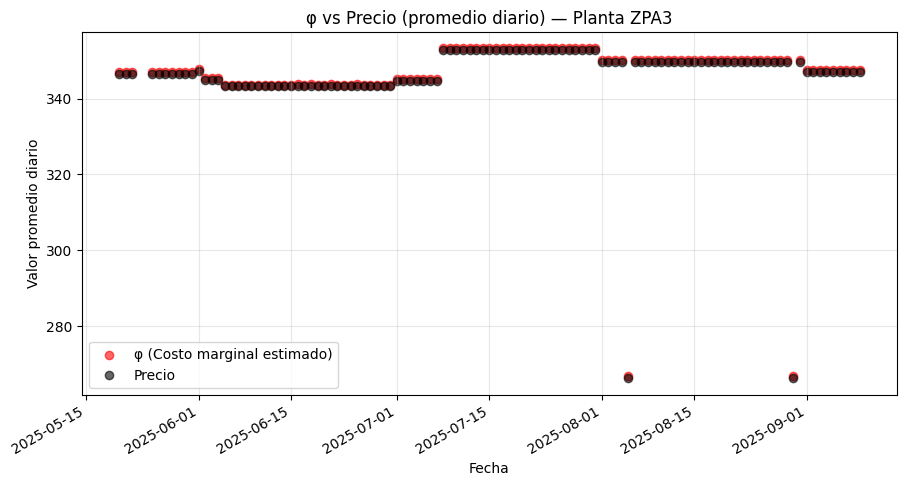

✅ Gráfico guardado: results\fechas_162\phi_precio_ZPA3_2025-05-20_to_2025-09-09_M1.png


In [71]:
import os
import matplotlib.pyplot as plt
import pandas as pd

M=1
# --- Asegurar formatos ---
df_result2['phi'] = pd.to_numeric(df_result2['phi'], errors='coerce')
df_result2['precio_d'] = pd.to_numeric(df_result2['precio_d'], errors='coerce')


# --- Filtrar filas válidas ---
df_result2 = df_result2.dropna(subset=['Fecha', 'CodigoPlanta', 'phi', 'precio_d'])

# --- Iterar sobre cada planta ---
for planta in df_result2['CodigoPlanta'].unique():
    df_planta = (
        df_result2[df_result2['CodigoPlanta'] == planta]
        .groupby('Fecha', as_index=False)[['phi', 'precio_d']].mean()
        .sort_values('Fecha')
    )

    plt.figure(figsize=(9, 5))
    plt.scatter(df_planta['Fecha'], df_planta['phi'], color='red', label='φ (Costo marginal estimado)', alpha=0.6)
    plt.scatter(df_planta['Fecha'], df_planta['precio_d'], color='black', label='Precio', alpha=0.6)

    plt.xlabel("Fecha")
    plt.ylabel("Valor promedio diario")
    plt.title(f"φ vs Precio (promedio diario) — Planta {planta}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()

    # --- Guardar figura ---
    fecha_min = df_planta['Fecha'].min()
    fecha_max = df_planta['Fecha'].max()
    filename = f"phi_precio_{planta}_{fecha_min}_to_{fecha_max}_M{M}.png"
    filepath = os.path.join(sub_dir, filename)
    plt.savefig(filepath, dpi=300)
    plt.show()

    print(f"✅ Gráfico guardado: {filepath}")

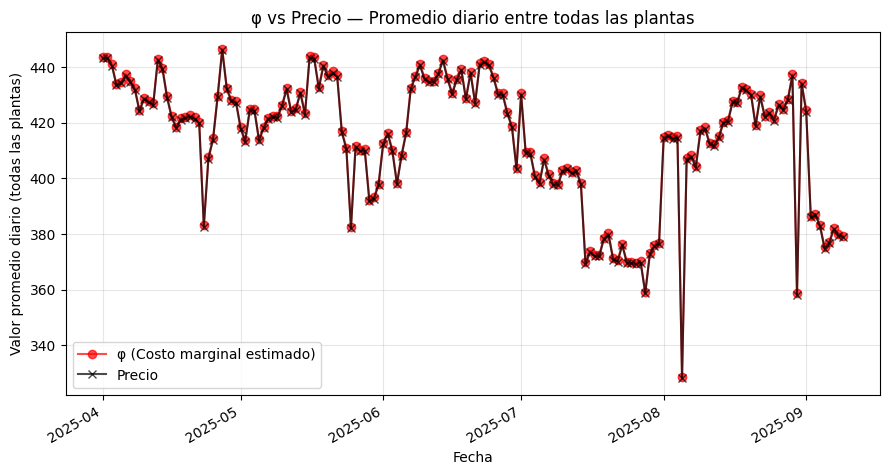

✅ Gráfico promedio guardado: results\fechas_162\phi_precio_promedio_2025-04-01_to_2025-09-09_M1.png


In [76]:
import os
import matplotlib.pyplot as plt
import pandas as pd

M = 1

# --- Asegurar formatos ---
df_result2['phi'] = pd.to_numeric(df_result2['phi'], errors='coerce')
df_result2['precio_d'] = pd.to_numeric(df_result2['precio_d'], errors='coerce')

# --- Filtrar filas válidas ---
df_result2 = df_result2.dropna(subset=['Fecha', 'CodigoPlanta', 'phi', 'precio_d'])

# --- Promedio por día entre todas las plantas ---
df_promedio = (
    df_result2.groupby('Fecha', as_index=False)[['phi', 'precio_d']].mean()
    .sort_values('Fecha')
)

# --- Graficar ---
plt.figure(figsize=(9, 5))
plt.plot(df_promedio['Fecha'], df_promedio['phi'], color='red', marker='o', label='φ (Costo marginal estimado)', alpha=0.7)
plt.plot(df_promedio['Fecha'], df_promedio['precio_d'], color='black', marker='x', label='Precio', alpha=0.7)

plt.xlabel("Fecha")
plt.ylabel("Valor promedio diario (todas las plantas)")
plt.title("φ vs Precio — Promedio diario entre todas las plantas")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()

# --- Guardar figura ---
fecha_min = df_promedio['Fecha'].min()
fecha_max = df_promedio['Fecha'].max()
filename = f"phi_precio_promedio_{fecha_min}_to_{fecha_max}_M{M}.png"
filepath = os.path.join(sub_dir, filename)
plt.savefig(filepath, dpi=300)
plt.show()

print(f"✅ Gráfico promedio guardado: {filepath}")


In [77]:
df_promedio

Fecha         phi    precio_d
0    2025-04-01  443.599143  443.099143
1    2025-04-02  443.733971  443.233971
2    2025-04-03  440.955373  440.455373
3    2025-04-04  433.885303  433.385303
4    2025-04-05  434.662879  434.162879
..          ...         ...         ...
157  2025-09-05  375.235909  374.735909
158  2025-09-06  377.165294  376.665294
159  2025-09-07  382.138358  381.638358
160  2025-09-08  379.962239  379.462239
161  2025-09-09  379.432388  378.932388

[162 rows x 3 columns]

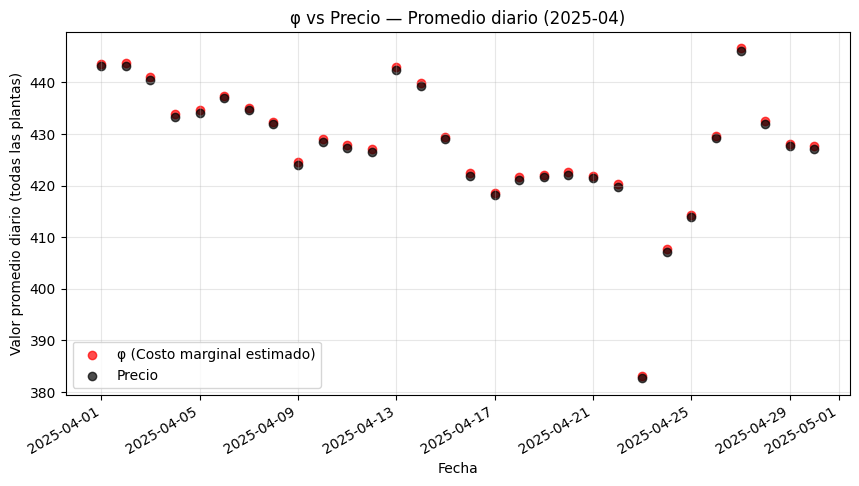

✅ Gráfico mensual guardado: results\fechas_162\phi_precio_promedio_2025-04_2025-04-01_to_2025-04-30_M1.png


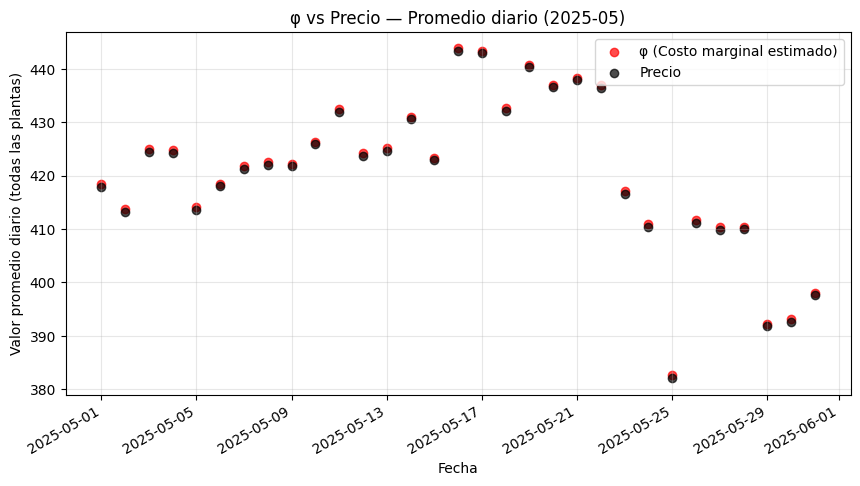

✅ Gráfico mensual guardado: results\fechas_162\phi_precio_promedio_2025-05_2025-05-01_to_2025-05-31_M1.png


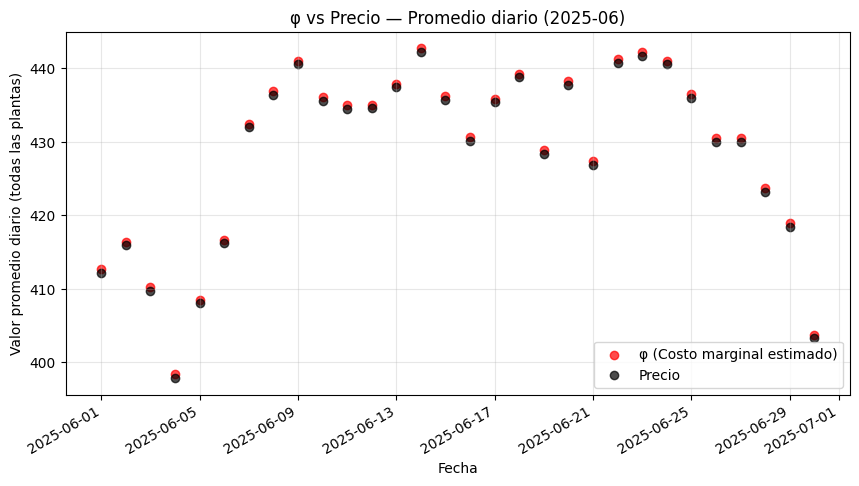

✅ Gráfico mensual guardado: results\fechas_162\phi_precio_promedio_2025-06_2025-06-01_to_2025-06-30_M1.png


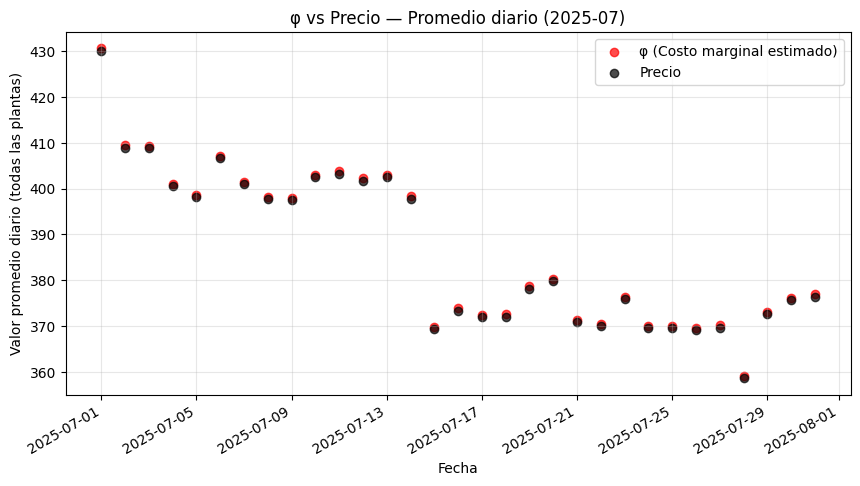

✅ Gráfico mensual guardado: results\fechas_162\phi_precio_promedio_2025-07_2025-07-01_to_2025-07-31_M1.png


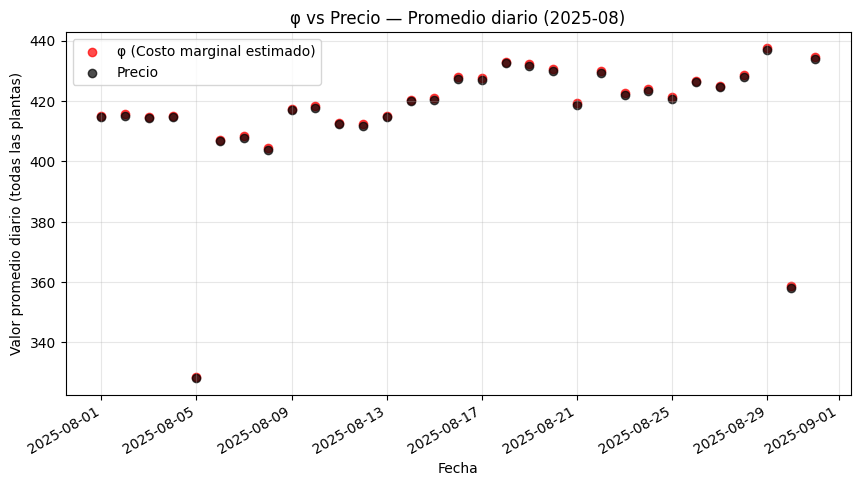

✅ Gráfico mensual guardado: results\fechas_162\phi_precio_promedio_2025-08_2025-08-01_to_2025-08-31_M1.png


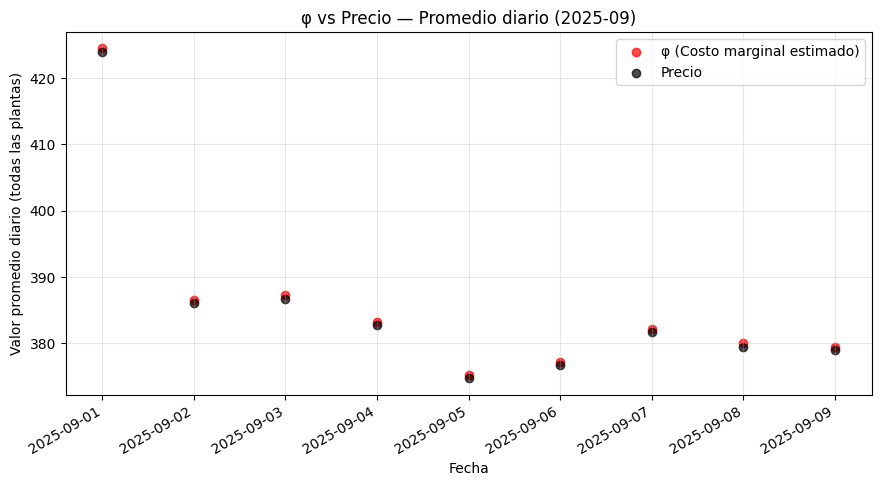

✅ Gráfico mensual guardado: results\fechas_162\phi_precio_promedio_2025-09_2025-09-01_to_2025-09-09_M1.png


In [79]:
import os
import matplotlib.pyplot as plt
import pandas as pd

M = 1

# --- Asegurar formatos ---
df_result2['phi'] = pd.to_numeric(df_result2['phi'], errors='coerce')
df_result2['precio_d'] = pd.to_numeric(df_result2['precio_d'], errors='coerce')
df_result2['Fecha'] = pd.to_datetime(df_result2['Fecha'], errors='coerce')

# --- Filtrar filas válidas ---
df_result2 = df_result2.dropna(subset=['Fecha', 'CodigoPlanta', 'phi', 'precio_d'])

# --- Promedio diario entre todas las plantas ---
df_promedio = (
    df_result2.groupby('Fecha', as_index=False)[['phi', 'precio_d']].mean()
    .sort_values('Fecha')
)

# --- Crear columna de mes-año ---
df_promedio['mes_anio'] = df_promedio['Fecha'].dt.to_period('M')

# --- Iterar por mes ---
for mes, df_mes in df_promedio.groupby('mes_anio'):
    plt.figure(figsize=(9, 5))
    plt.scatter(df_mes['Fecha'], df_mes['phi'], color='red',
                label='φ (Costo marginal estimado)', alpha=0.7)
    plt.scatter(df_mes['Fecha'], df_mes['precio_d'], color='black',
                label='Precio', alpha=0.7)

    plt.xlabel("Fecha")
    plt.ylabel("Valor promedio diario (todas las plantas)")
    plt.title(f"φ vs Precio — Promedio diario ({mes})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()

    # --- Guardar figura ---
    fecha_min = df_mes['Fecha'].min().strftime("%Y-%m-%d")
    fecha_max = df_mes['Fecha'].max().strftime("%Y-%m-%d")
    filename = f"phi_precio_promedio_{mes}_{fecha_min}_to_{fecha_max}_M{M}.png"
    filepath = os.path.join(sub_dir, filename)
    plt.savefig(filepath, dpi=300)
    plt.show()

    print(f"✅ Gráfico mensual guardado: {filepath}")


In [72]:
df_result2

Fecha CodigoPlanta     numerador   denominador  precio_d     phi
0      2025-04-01         2QEK  6.518729e+06  1.303746e+07    113.37  113.87
1      2025-04-01         3DDT  5.029743e+06  1.005949e+07    107.37  107.87
2      2025-04-01         3ENA  1.307657e+07  2.615314e+07    889.28  889.78
3      2025-04-01         3HF5  3.521098e+06  7.042197e+06    107.37  107.87
4      2025-04-01         3INX  9.801487e+06  1.960297e+07     97.37   97.87
...           ...          ...           ...           ...       ...     ...
11198  2025-09-09         URA1  5.313911e+06  1.062782e+07    118.94  119.44
11199  2025-09-09         ZPA2  6.443716e+06  1.288743e+07    372.94  373.44
11200  2025-09-09         ZPA3  5.313911e+06  1.062782e+07    346.94  347.44
11201  2025-09-09         ZPA4  4.744222e+06  9.488443e+06    360.94  361.44
11202  2025-09-09         ZPA5  5.313911e+06  1.062782e+07    338.94  339.44

[11203 rows x 6 columns]

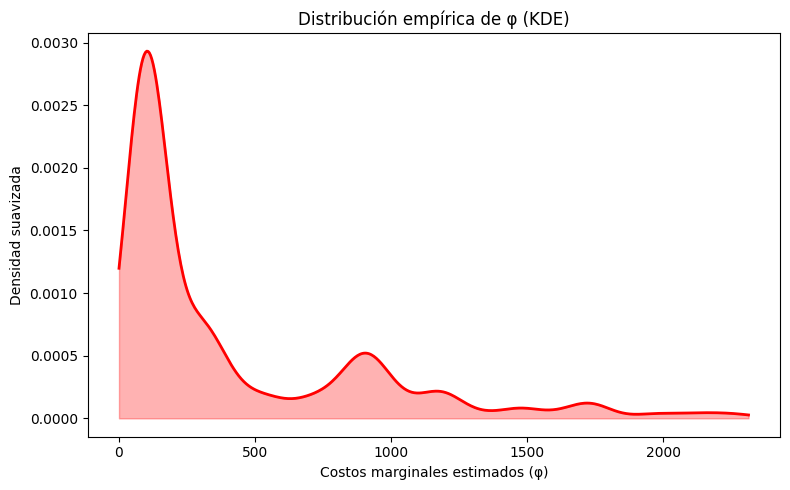

In [73]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

phi = pd.to_numeric(df_result2['phi'], errors='coerce').dropna()

# Calcular densidad KDE
kde = gaussian_kde(phi)
x_vals = np.linspace(phi.min(), phi.max(), 500)
y_vals = kde(x_vals)

plt.figure(figsize=(8,5))
plt.plot(x_vals, y_vals, color="red", linewidth=2)
plt.fill_between(x_vals, y_vals, color="red", alpha=0.3)
plt.xlabel("Costos marginales estimados (φ)")
plt.ylabel("Densidad suavizada")
plt.title("Distribución empírica de φ (KDE)")
plt.tight_layout()
plt.show()




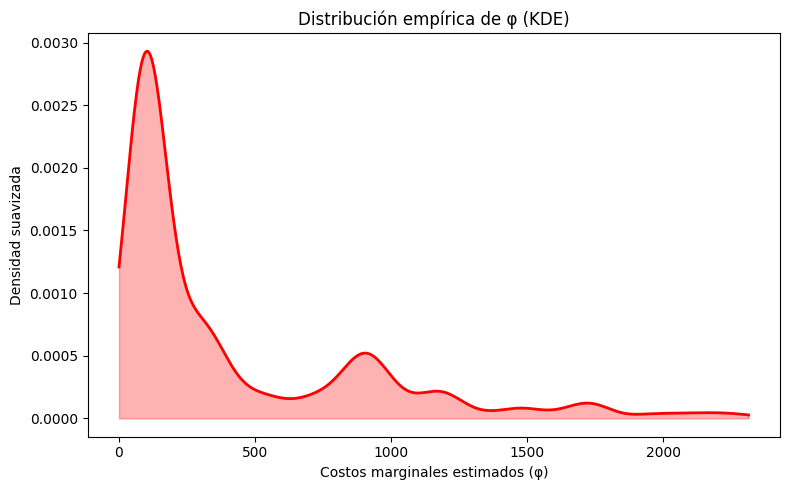

In [80]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

precio_d = pd.to_numeric(df_result2['precio_d'], errors='coerce').dropna()

# Calcular densidad KDE
kde = gaussian_kde(precio_d)
x_vals = np.linspace(phi.min(), phi.max(), 500)
y_vals = kde(x_vals)

plt.figure(figsize=(8,5))
plt.plot(x_vals, y_vals, color="red", linewidth=2)
plt.fill_between(x_vals, y_vals, color="red", alpha=0.3)
plt.xlabel("Costos marginales estimados (φ)")
plt.ylabel("Densidad suavizada")
plt.title("Distribución empírica de φ (KDE)")
plt.tight_layout()
plt.show()


In [104]:
df_result2 = df_result2.sort_values(by='Fecha', ascending=True)
df_result2

Fecha CodigoPlanta     numerador   denominador  precio_d      phi  \
47    2025-04-01         TBQ3  1.529243e+07  3.058485e+07   1442.05  1442.55   
59    2025-04-01         TSJ1  1.312927e+07  2.625854e+07    310.37   310.87   
69    2025-04-01         ZPA5  1.283156e+07  2.566312e+07    344.37   344.87   
32    2025-04-01         PGUG  6.782371e+06  1.356474e+07    104.61   105.11   
65    2025-04-01         TYP4  1.160444e+07  2.320889e+07    101.37   101.87   
...          ...          ...           ...           ...       ...      ...   
11169 2025-09-09         PLYS  4.744222e+06  9.488443e+06    102.02   102.52   
11188 2025-09-09         TGJ1  4.744222e+06  9.488443e+06    519.16   519.66   
11179 2025-09-09         SMI1  7.196919e+06  1.439384e+07     95.00    95.50   
11140 2025-09-09         3INX  3.410159e+06  6.820317e+06     86.94    87.44   
11174 2025-09-09         PRDO  6.443716e+06  1.288743e+07    127.94   128.44   

      YearMonth  diff_phi_precio  
47      2025-04              0.5  
59      2025-04              0.5  
69      2025-04              0.5  
32      2025-04              0.5  
65      2025-04              0.5  
...         ...              ...  
11169   2025-09              0.5  
11188   2025-09              0.5  
11179   2025-09              0.5  
11140   2025-09              0.5  
11174   2025-09              0.5  

[11203 rows x 8 columns]

In [98]:
pd.reset_option('display.max_rows', None)